In [ ]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pandas import Series
import numpy.linalg as npl
from numpy import load,save 
from random import randrange
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KernelDensity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams["figure.figsize"] = (20,10)
import warnings
warnings.filterwarnings("ignore")




In [2]:
plt.rcParams["figure.figsize"] = (20,10)
import sys 
sys.path.append(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Code')
from pca_ad_utils import *
from decomp_utils import *
from customizedLossSynthetic import *
from LocationAnomalyPCA import *
from utilsImputation import *


sys.path.append(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Code\DataGenerator')
from ParamsEstimationUtils import *
sys.path.append(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Code\DataGenerator')
from syntheticDataGeneratorUtils import *

sys.path.append(r'C:\Users\nmadhar\Desktop\Conv_deep\Review\Code')
from sensitivity_amplishocks_utils import *
sys.path.append(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Code')

from LocationAnomalyPCA import *


In [3]:
nStocks = 20
T = 1
M = int(2.**10)
Ntrain = int(2.**10)
Ntest = int(2.**9)
N = Ntrain + Ntest
k=20

alpha = 0.9
windowSize = 206
upBound=0.04
AnoNumber = 5
isimul = 0

Cov = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Code\DataGenerator\Params\Cov.csv').drop(['Unnamed: 0'],axis=1).values
S0 = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Code\DataGenerator\Params\S0.csv').drop(['Unnamed: 0'],axis=1).values.reshape(-1,)
mu = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Code\DataGenerator\Params\mu.csv').drop(['Unnamed: 0'],axis=1).values.reshape(-1,)
sigma = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Code\DataGenerator\Params\Sigma.csv').drop(['Unnamed: 0'],axis=1).values.reshape(-1,)


In [4]:
CalibParamsLoaded = load(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Results\Model\CalibParams2405_2.pkl',allow_pickle=True)
netLoaded = NeuralNetwork()
netLoaded.load_state_dict(torch.load(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Results\Model\modelCustomLoss2405_2.h5'))

<All keys matched successfully>

In [5]:
X_trainUnderdf = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Data\XTrainUnder.csv').drop(['Unnamed: 0'],axis=1)
y_trainUnderdf = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Data\yTrainUnder.csv').drop(['Unnamed: 0'],axis=1)

X_testUnderdf = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Data\XTestUnder.csv').drop(['Unnamed: 0'],axis=1)
y_testUnderdf = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Data\yTestUnder.csv').drop(['Unnamed: 0'],axis=1)
X_trainUnder = np.array(X_trainUnderdf.iloc[:,:-3])
X_testUnder = np.array(X_testUnderdf.iloc[:,:-3])

y_trainUnder = np.array(y_trainUnderdf['NbAnomaly'])
y_testUnder = np.array(y_testUnderdf['NbAnomaly'])
ytrainUnder = np.array([1 if l==1 else 0 for l in y_trainUnder])
ytestUnder = np.array([1 if l==1 else 0 for l in y_testUnder])

print(f'Normal observations in train set {list(y_trainUnder).count(0)}')
print(f'Outlier observations in train set {list(y_trainUnder).count(1)} \n')

print(f'Normal observations in test set {list(y_testUnder).count(0)}')
print(f'Outlier observations in test set {list(y_testUnder).count(1)}')

Normal observations in train set 6010
Outlier observations in train set 6010 

Normal observations in test set 2109
Outlier observations in test set 421


In [6]:
modelPCAID = PCA(n_components=k)
modelPCAID.fit(X_trainUnder)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [7]:
X_traindf = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Data\XTrainLoc.csv').drop(['Unnamed: 0'],axis=1)
y_traindf = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Data\yTrainLoc.csv').drop(['Unnamed: 0'],axis=1)

X_testdf = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Data\XTestLoc.csv').drop(['Unnamed: 0'],axis=1)
y_testdf = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Data\yTestLoc.csv').drop(['Unnamed: 0'],axis=1)

Xtrain = np.array(X_traindf.iloc[:,:-3])
Xtest = np.array(X_testdf.iloc[:,:-3])

ytrain_loc = [list(y_traindf.iloc[i,:]).index(1)for i in range(y_traindf.shape[0]) ]

ytest_loc = [list(y_testdf.iloc[i,:]).index(1) for i in range(y_testdf.shape[0]) ]
ntrain,d = Xtrain.shape
ntest = Xtest.shape[0]


In [8]:
modelPCALoc = PCA(n_components=k)
modelPCALoc.fit(Xtrain)




In [67]:
nStocks = 20

nSimultation = 100

Sparams = [100,1]
DriftParams = [0.01,0.1]
SigmaParams = [0.01,0.1]
T = 1
Ntrain = int(2.**10)
Ntest  = int(2.**9)


alpha = 1
windowSize = 206
upBound = 0.04
AnoNumberTrain = 4
AnoNumberTest = 2
ContaminationParams = [alpha,windowSize,upBound,AnoNumberTrain,AnoNumberTest]

lag = 1
SliddingParams = [windowSize,lag]

ContaminationRate = 0.2
UnderSampParams = [ContaminationRate]
Nbsim = 10
upBoundVect = [0.005,0.01,0.02,0.03,0.04,0.05,0.1,0.2,0.3,0.4,0.5]
#upBoundVect = [0.005,0.01]


In [68]:
empty = pd.DataFrame(columns=['Ampli','Acc','Prec','Rec','F1'],index=np.arange(Nbsim*len(upBoundVect)))
empty['Ampli'] = [i  for i in upBoundVect for j in range(Nbsim)]


In [69]:
ScoreswrtAmplishocksID ={'Train':deepcopy(empty),'Test':deepcopy(empty)}
ScoreswrtAmplishocksLoc ={'Train':deepcopy(empty),'Test':deepcopy(empty)}
ScoreswrtAmplishocksID['Train']

,Ampli,Acc,Prec,Rec,F1
0,0.005,NaN,NaN,NaN,NaN
1,0.005,NaN,NaN,NaN,NaN
2,0.005,NaN,NaN,NaN,NaN
3,0.005,NaN,NaN,NaN,NaN
4,0.005,NaN,NaN,NaN,NaN
...,...,...,...,...,...
105,0.500,NaN,NaN,NaN,NaN
106,0.500,NaN,NaN,NaN,NaN
107,0.500,NaN,NaN,NaN,NaN
108,0.500,NaN,NaN,NaN,NaN


In [70]:
idx = 0
for upBound in tqdm(upBoundVect):
    ContaminationParams = [alpha,windowSize,upBound,AnoNumberTrain,AnoNumberTest]

    EvalTrain = np.zeros((Nbsim,4))
    EvalTest = np.zeros((Nbsim,4))
    
    EvalTrainLoc = np.zeros((Nbsim,4))
    EvalTestLoc = np.zeros((Nbsim,4))

    for i in range(Nbsim):
        iSimul = np.random.randint(0,10000)
        DataIdentification, DataLocation,DataOriginal = GenerateData(nStocks,S0,mu,sigma,Cov,T,Ntrain,Ntest,iSimul,
                         ContaminationParams, SliddingParams,UnderSampParams)

        XtrainUnderdf,ytrainUnderdf = DataIdentification['Train']
        XtestUnderdf,ytestUnderdf = DataIdentification['Test']

        XTrainLoc,yTrainLoc = DataLocation['Train']
        XTestLoc,yTestLoc = DataLocation['Test']


        X_trainUnder = np.array(XtrainUnderdf.iloc[:,:-3])
        X_testUnder = np.array(XtestUnderdf.iloc[:,:-3])

        y_trainUnder = np.array(ytrainUnderdf['NbAnomaly'])
        y_testUnder = np.array(ytestUnderdf['NbAnomaly'])
        ytrainUnder = np.array([1 if l==1 else 0 for l in y_trainUnder])
        ytestUnder = np.array([1 if l==1 else 0 for l in y_testUnder])

        print(f'Normal observations in train set {list(y_trainUnder).count(0)}')
        print(f'Outlier observations in train set {list(y_trainUnder).count(1)} \n')

        print(f'Normal observations in test set {list(y_testUnder).count(0)}')
        print(f'Outlier observations in test set {list(y_testUnder).count(1)}')



        
        r_train = modelPCAID.inverse_transform(modelPCAID.transform(X_trainUnder))
        r_test = modelPCAID.inverse_transform(modelPCAID.transform(X_testUnder))

        # 1. Data Preparation for NN 

        reconsRawTrain = r_train
        reconsRawTest = r_test


        reconsRawTrain = torch.tensor(reconsRawTrain)
        ytrain = torch.tensor(ytrainUnder.reshape(-1,1))


        reconsRawTest = torch.tensor(reconsRawTest)
        ytest = torch.tensor(ytestUnder.reshape(-1,1))
        xtrain = np.array(X_trainUnder,dtype=float)
        ytrain = np.array(y_trainUnder,dtype=float)

        xtest = np.array(X_testUnder,dtype=float)
        ytest = np.array(y_testUnder,dtype=float)

        xtrain = torch.tensor(xtrain)
        ytrain = torch.tensor(ytrain.reshape(-1,1))


        xtest = torch.tensor(xtest)
        ytest = torch.tensor(ytest.reshape(-1,1))

        ErrRawTrain = xtrain - reconsRawTrain
        ErrRawTrain = torch.tensor(ErrRawTrain)

        ErrRawTest = xtest - reconsRawTest
        ErrRawTest = torch.tensor(ErrRawTest)


        STrain,scoresTrain  = evalPerf(netLoaded,ErrRawTrain,ytrain,'Train',CalibParamsLoaded)
        STest,scoresTest  = evalPerf(netLoaded,ErrRawTest,ytest,'Test',CalibParamsLoaded)

        
        
        ScoreswrtAmplishocksID['Train'].iloc[idx,1:] = scoresTrain
        ScoreswrtAmplishocksID['Test'].iloc[idx,1:] = scoresTest
        
        
        
        
        Xtrain = np.array(XTrainLoc.iloc[:,:-3])
        Xtest = np.array(XTestLoc.iloc[:,:-3])

        ytrain_loc = [list(yTrainLoc.iloc[i,:]).index(1)for i in range(yTrainLoc.shape[0]) ]

        ytest_loc = [list(yTestLoc.iloc[i,:]).index(1) for i in range(yTestLoc.shape[0]) ]
        ntrain,d = Xtrain.shape
        ntest = Xtest.shape[0]
        k = 20

        norms_train, norms_test =  modelPCALocation(modelPCALoc,Xtrain,Xtest,k)

        pred_loc_train = dummyprediction(norms_train)
        ScoresTrainPCA = EvaluationPred(yPred = pred_loc_train,yTrue=ytrain_loc)

        pred_loc_test = dummyprediction(norms_test)
        ScoresTestPCA = EvaluationPred(yPred = pred_loc_test,yTrue=ytest_loc)


        printRes(ScoresTrainPCA,'Train')
        printRes(ScoresTestPCA,'Test')
        
        EvalTrainLoc[i,:]=ScoresTrainPCA
        EvalTestLoc[i,:]= ScoresTestPCA
        
        ScoreswrtAmplishocksLoc['Train'].iloc[idx,1:] = ScoresTrainPCA
        ScoreswrtAmplishocksLoc['Test'].iloc[idx,1:] = ScoresTestPCA
        idx +=1
    
    

    
    
    

        
        

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

Normal observations in train set 5888
Outlier observations in train set 5888 

Normal observations in test set 2444
Outlier observations in test set 488
-------------------Scores on Train set-------------------
Accuracy :  0.5309
Precision :  0.5787
Recall :  0.2274
F1-score: 0.3265


-------------------Scores on Test set-------------------
Accuracy :  0.7261
Precision :  0.2045
Recall :  0.2234
F1-score: 0.2135





100%|████████████████████████████████████████████████████████████████████████████| 3696/3696 [00:01<00:00, 3069.80it/s]

------------Scores on Train-------------
Accuracy: 0.3325993883792049
Recall: 0.3325993883792049
Precision: 0.3590452430741385
F1-score: 0.3390728547583058

------------Scores on Test-------------
Accuracy: 0.34686147186147187
Recall: 0.34686147186147187
Precision: 0.38022138989431464
F1-score: 0.35445060755876945

Normal observations in train set 5440
Outlier observations in train set 5440 

Normal observations in test set 1572
Outlier observations in test set 314
-------------------Scores on Train set-------------------
Accuracy :  0.5088
Precision :  0.5269
Recall :  0.1728
F1-score: 0.2602


-------------------Scores on Test set-------------------
Accuracy :  0.7365
Precision :  0.2393
Recall :  0.2675
F1-score: 0.2526





100%|████████████████████████████████████████████████████████████████████████████| 4568/4568 [00:00<00:00, 4808.45it/s]

------------Scores on Train-------------
Accuracy: 0.2886803519061584
Recall: 0.2886803519061584
Precision: 0.3096252491344664
F1-score: 0.2922977736729806

------------Scores on Test-------------
Accuracy: 0.34413309982486867
Recall: 0.34413309982486867
Precision: 0.3722548646448781
F1-score: 0.34913408628925224

Normal observations in train set 5540
Outlier observations in train set 5540 

Normal observations in test set 1821
Outlier observations in test set 364
-------------------Scores on Train set-------------------
Accuracy :  0.4968
Precision :  0.4915
Recall :  0.1821
F1-score: 0.2658


-------------------Scores on Test set-------------------
Accuracy :  0.7680
Precision :  0.2509
Recall :  0.1978
F1-score: 0.2212





100%|████████████████████████████████████████████████████████████████████████████| 4319/4319 [00:00<00:00, 7586.42it/s]

------------Scores on Train-------------
Accuracy: 0.33550302615050814
Recall: 0.33550302615050814
Precision: 0.3587651060099722
F1-score: 0.3407167430830064

------------Scores on Test-------------
Accuracy: 0.2829358647835147
Recall: 0.2829358647835147
Precision: 0.32116454914701564
F1-score: 0.29027404994028394

Normal observations in train set 6406
Outlier observations in train set 6406 

Normal observations in test set 1892
Outlier observations in test set 378
-------------------Scores on Train set-------------------
Accuracy :  0.5104
Precision :  0.5299
Recall :  0.1837
F1-score: 0.2729


-------------------Scores on Test set-------------------
Accuracy :  0.7251
Precision :  0.2071
Recall :  0.2302
F1-score: 0.2180





100%|████████████████████████████████████████████████████████████████████████████| 4248/4248 [00:00<00:00, 7720.33it/s]

------------Scores on Train-------------
Accuracy: 0.3971709887671613
Recall: 0.3971709887671613
Precision: 0.4252846151718825
F1-score: 0.4030155900359217

------------Scores on Test-------------
Accuracy: 0.3159133709981168
Recall: 0.3159133709981168
Precision: 0.3405378683996612
F1-score: 0.32068203209201274

Normal observations in train set 5920
Outlier observations in train set 5920 

Normal observations in test set 1633
Outlier observations in test set 326
-------------------Scores on Train set-------------------
Accuracy :  0.5144
Precision :  0.5378
Recall :  0.2052
F1-score: 0.2971


-------------------Scores on Test set-------------------
Accuracy :  0.7055
Precision :  0.1485
Recall :  0.1626
F1-score: 0.1552





100%|████████████████████████████████████████████████████████████████████████████| 4507/4507 [00:00<00:00, 8248.41it/s]

------------Scores on Train-------------
Accuracy: 0.28663286756522816
Recall: 0.28663286756522816
Precision: 0.3070619149638214
F1-score: 0.2894523736121357

------------Scores on Test-------------
Accuracy: 0.3088528954958953
Recall: 0.3088528954958953
Precision: 0.35230870066804887
F1-score: 0.31617531355005324

Normal observations in train set 6039
Outlier observations in train set 6039 

Normal observations in test set 2142
Outlier observations in test set 428
-------------------Scores on Train set-------------------
Accuracy :  0.5298
Precision :  0.5845
Recall :  0.2062
F1-score: 0.3048


-------------------Scores on Test set-------------------
Accuracy :  0.6673
Precision :  0.1387
Recall :  0.1916
F1-score: 0.1609





100%|████████████████████████████████████████████████████████████████████████████| 3998/3998 [00:00<00:00, 6717.32it/s]

------------Scores on Train-------------
Accuracy: 0.2432106216053108
Recall: 0.2432106216053108
Precision: 0.2641828573768661
F1-score: 0.2479873183068766

------------Scores on Test-------------
Accuracy: 0.35342671335667836
Recall: 0.35342671335667836
Precision: 0.3944141731865172
F1-score: 0.3610712741065024

Normal observations in train set 5503
Outlier observations in train set 5503 

Normal observations in test set 1834
Outlier observations in test set 366
-------------------Scores on Train set-------------------
Accuracy :  0.4989
Precision :  0.4964
Recall :  0.1508
F1-score: 0.2314


-------------------Scores on Test set-------------------
Accuracy :  0.7141
Precision :  0.1831
Recall :  0.2077
F1-score: 0.1946





100%|████████████████████████████████████████████████████████████████████████████| 4306/4306 [00:00<00:00, 6855.80it/s]

------------Scores on Train-------------
Accuracy: 0.32938856015779094
Recall: 0.32938856015779094
Precision: 0.3550264144850619
F1-score: 0.33566453000417035

------------Scores on Test-------------
Accuracy: 0.2633534602879703
Recall: 0.2633534602879703
Precision: 0.2863658581304621
F1-score: 0.2654180807020353

Normal observations in train set 4857
Outlier observations in train set 4857 

Normal observations in test set 1675
Outlier observations in test set 335
-------------------Scores on Train set-------------------
Accuracy :  0.5045
Precision :  0.5142
Recall :  0.1641
F1-score: 0.2488


-------------------Scores on Test set-------------------
Accuracy :  0.6532
Precision :  0.1306
Recall :  0.1910
F1-score: 0.1552





100%|████████████████████████████████████████████████████████████████████████████| 4465/4465 [00:00<00:00, 7882.80it/s]

------------Scores on Train-------------
Accuracy: 0.2946494270997582
Recall: 0.2946494270997582
Precision: 0.32868424423115644
F1-score: 0.3034892823004867

------------Scores on Test-------------
Accuracy: 0.3393057110862262
Recall: 0.3393057110862262
Precision: 0.3798490735667629
F1-score: 0.34765009788025786

Normal observations in train set 5634
Outlier observations in train set 5634 

Normal observations in test set 2014
Outlier observations in test set 402
-------------------Scores on Train set-------------------
Accuracy :  0.4847
Precision :  0.4560
Recall :  0.1583
F1-score: 0.2350


-------------------Scores on Test set-------------------
Accuracy :  0.7285
Precision :  0.2127
Recall :  0.2338
F1-score: 0.2227





100%|████████████████████████████████████████████████████████████████████████████| 4126/4126 [00:00<00:00, 7078.43it/s]

------------Scores on Train-------------
Accuracy: 0.30545599362803666
Recall: 0.30545599362803666
Precision: 0.32933461328842656
F1-score: 0.3095000428011942

------------Scores on Test-------------
Accuracy: 0.3364032961706253
Recall: 0.3364032961706253
Precision: 0.35990448620834103
F1-score: 0.33974220143439837

Normal observations in train set 6092
Outlier observations in train set 6092 

Normal observations in test set 2138
Outlier observations in test set 427
-------------------Scores on Train set-------------------
Accuracy :  0.5219
Precision :  0.5597
Recall :  0.2055
F1-score: 0.3006


-------------------Scores on Test set-------------------
Accuracy :  0.7404
Precision :  0.1896
Recall :  0.1710
F1-score: 0.1798





100%|████████████████████████████████████████████████████████████████████████████| 4002/4002 [00:00<00:00, 4938.88it/s]

------------Scores on Train-------------
Accuracy: 0.2924722336487042
Recall: 0.2924722336487042
Precision: 0.31453837035741916
F1-score: 0.29657773327428116

------------Scores on Test-------------
Accuracy: 0.3268365817091454
Recall: 0.3268365817091454
Precision: 0.3521225014131737
F1-score: 0.3252945144655645



  9%|███████▍                                                                          | 1/11 [02:37<26:13, 157.40s/it]

Normal observations in train set 6267
Outlier observations in train set 6267 

Normal observations in test set 2268
Outlier observations in test set 453
-------------------Scores on Train set-------------------
Accuracy :  0.5586
Precision :  0.6301
Recall :  0.2840
F1-score: 0.3916


-------------------Scores on Test set-------------------
Accuracy :  0.6909
Precision :  0.2113
Recall :  0.3135
F1-score: 0.2524





100%|████████████████████████████████████████████████████████████████████████████| 3872/3872 [00:00<00:00, 7177.42it/s]

------------Scores on Train-------------
Accuracy: 0.5634218289085545
Recall: 0.5634218289085545
Precision: 0.5901881662505222
F1-score: 0.5681742544422294

------------Scores on Test-------------
Accuracy: 0.5978822314049587
Recall: 0.5978822314049587
Precision: 0.6179703264634241
F1-score: 0.5983475271804571

Normal observations in train set 5195
Outlier observations in train set 5195 

Normal observations in test set 1651
Outlier observations in test set 330
-------------------Scores on Train set-------------------
Accuracy :  0.5439
Precision :  0.6012
Recall :  0.2608
F1-score: 0.3638


-------------------Scores on Test set-------------------
Accuracy :  0.7627
Precision :  0.3250
Recall :  0.3939
F1-score: 0.3562





100%|████████████████████████████████████████████████████████████████████████████| 4489/4489 [00:00<00:00, 6237.14it/s]

------------Scores on Train-------------
Accuracy: 0.5850688517127575
Recall: 0.5850688517127575
Precision: 0.6017983245201357
F1-score: 0.5895677502029669

------------Scores on Test-------------
Accuracy: 0.6743149922031633
Recall: 0.6743149922031633
Precision: 0.6922665231081606
F1-score: 0.6794944746448337

Normal observations in train set 4919
Outlier observations in train set 4919 

Normal observations in test set 2279
Outlier observations in test set 455
-------------------Scores on Train set-------------------
Accuracy :  0.5485
Precision :  0.6004
Recall :  0.2899
F1-score: 0.3910


-------------------Scores on Test set-------------------
Accuracy :  0.7593
Precision :  0.3216
Recall :  0.4022
F1-score: 0.3574





100%|████████████████████████████████████████████████████████████████████████████| 3861/3861 [00:00<00:00, 6782.61it/s]

------------Scores on Train-------------
Accuracy: 0.579349698535745
Recall: 0.579349698535745
Precision: 0.5997224586296004
F1-score: 0.584898077034813

------------Scores on Test-------------
Accuracy: 0.667961667961668
Recall: 0.667961667961668
Precision: 0.6933295635670157
F1-score: 0.6740960956050184

Normal observations in train set 5751
Outlier observations in train set 5751 

Normal observations in test set 1883
Outlier observations in test set 376
-------------------Scores on Train set-------------------
Accuracy :  0.5586
Precision :  0.6179
Recall :  0.3071
F1-score: 0.4103


-------------------Scores on Test set-------------------
Accuracy :  0.7689
Precision :  0.3016
Recall :  0.2952
F1-score: 0.2984





100%|████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:00<00:00, 7195.73it/s]

------------Scores on Train-------------
Accuracy: 0.533366910098212
Recall: 0.533366910098212
Precision: 0.5498417119568374
F1-score: 0.5369235403018934

------------Scores on Test-------------
Accuracy: 0.45971341320178527
Recall: 0.45971341320178527
Precision: 0.48811077796257235
F1-score: 0.4680093858152381

Normal observations in train set 5908
Outlier observations in train set 5908 

Normal observations in test set 1545
Outlier observations in test set 309
-------------------Scores on Train set-------------------
Accuracy :  0.5793
Precision :  0.6553
Recall :  0.3346
F1-score: 0.4430


-------------------Scores on Test set-------------------
Accuracy :  0.7956
Precision :  0.3856
Recall :  0.3819
F1-score: 0.3837





100%|████████████████████████████████████████████████████████████████████████████| 4595/4595 [00:00<00:00, 7548.60it/s]

------------Scores on Train-------------
Accuracy: 0.5316471624512394
Recall: 0.5316471624512394
Precision: 0.5562072293840455
F1-score: 0.5366956275291748

------------Scores on Test-------------
Accuracy: 0.432208922742111
Recall: 0.432208922742111
Precision: 0.46179056448968353
F1-score: 0.4388655620683251

Normal observations in train set 5434
Outlier observations in train set 5434 

Normal observations in test set 1793
Outlier observations in test set 358
-------------------Scores on Train set-------------------
Accuracy :  0.5881
Precision :  0.6877
Recall :  0.3226
F1-score: 0.4392


-------------------Scores on Test set-------------------
Accuracy :  0.7280
Precision :  0.2415
Recall :  0.2961
F1-score: 0.2660





100%|████████████████████████████████████████████████████████████████████████████| 4347/4347 [00:00<00:00, 7220.05it/s]

------------Scores on Train-------------
Accuracy: 0.5420592193808883
Recall: 0.5420592193808883
Precision: 0.5603696713551335
F1-score: 0.5465107895592707

------------Scores on Test-------------
Accuracy: 0.45686680469289165
Recall: 0.45686680469289165
Precision: 0.4878640715866042
F1-score: 0.46321748885888175

Normal observations in train set 6202
Outlier observations in train set 6202 

Normal observations in test set 1759
Outlier observations in test set 351
-------------------Scores on Train set-------------------
Accuracy :  0.5714
Precision :  0.6420
Recall :  0.3230
F1-score: 0.4297


-------------------Scores on Test set-------------------
Accuracy :  0.7299
Precision :  0.2645
Recall :  0.3504
F1-score: 0.3015





100%|████████████████████████████████████████████████████████████████████████████| 4381/4381 [00:00<00:00, 7686.67it/s]

------------Scores on Train-------------
Accuracy: 0.48300759367608614
Recall: 0.48300759367608614
Precision: 0.5106763850733157
F1-score: 0.48784831507873333

------------Scores on Test-------------
Accuracy: 0.6621775850262497
Recall: 0.6621775850262497
Precision: 0.6799584515720475
F1-score: 0.6669650304484895

Normal observations in train set 6491
Outlier observations in train set 6491 

Normal observations in test set 1951
Outlier observations in test set 390
-------------------Scores on Train set-------------------
Accuracy :  0.5236
Precision :  0.5525
Recall :  0.2488
F1-score: 0.3431


-------------------Scores on Test set-------------------
Accuracy :  0.7856
Precision :  0.3436
Recall :  0.3154
F1-score: 0.3289





100%|████████████████████████████████████████████████████████████████████████████| 4189/4189 [00:00<00:00, 6541.89it/s]

------------Scores on Train-------------
Accuracy: 0.5975119865232603
Recall: 0.5975119865232603
Precision: 0.621446092245499
F1-score: 0.6041267942211815

------------Scores on Test-------------
Accuracy: 0.45022678443542613
Recall: 0.45022678443542613
Precision: 0.466945407462966
F1-score: 0.454326658609536

Normal observations in train set 5756
Outlier observations in train set 5756 

Normal observations in test set 1792
Outlier observations in test set 358
-------------------Scores on Train set-------------------
Accuracy :  0.5618
Precision :  0.6537
Recall :  0.2630
F1-score: 0.3751


-------------------Scores on Test set-------------------
Accuracy :  0.7637
Precision :  0.3171
Recall :  0.3631
F1-score: 0.3385





100%|████████████████████████████████████████████████████████████████████████████| 4348/4348 [00:00<00:00, 6591.13it/s]

------------Scores on Train-------------
Accuracy: 0.48500619578686494
Recall: 0.48500619578686494
Precision: 0.5036787499169454
F1-score: 0.49000060988010596

------------Scores on Test-------------
Accuracy: 0.609015639374425
Recall: 0.609015639374425
Precision: 0.6209573687818934
F1-score: 0.6113219836498908

Normal observations in train set 6113
Outlier observations in train set 6113 

Normal observations in test set 2309
Outlier observations in test set 461
-------------------Scores on Train set-------------------
Accuracy :  0.6038
Precision :  0.7012
Recall :  0.3617
F1-score: 0.4772


-------------------Scores on Test set-------------------
Accuracy :  0.7267
Precision :  0.2566
Recall :  0.3384
F1-score: 0.2919





100%|████████████████████████████████████████████████████████████████████████████| 3831/3831 [00:00<00:00, 5864.70it/s]

------------Scores on Train-------------
Accuracy: 0.5807259073842302
Recall: 0.5807259073842302
Precision: 0.5943645768869549
F1-score: 0.5841127467873749

------------Scores on Test-------------
Accuracy: 0.6444792482380579
Recall: 0.6444792482380579
Precision: 0.6607565774963906
F1-score: 0.6473534319434687



 18%|██████████████▉                                                                   | 2/11 [05:03<23:07, 154.15s/it]

Normal observations in train set 5600
Outlier observations in train set 5600 

Normal observations in test set 1716
Outlier observations in test set 343
-------------------Scores on Train set-------------------
Accuracy :  0.6886
Precision :  0.7508
Recall :  0.5645
F1-score: 0.6444


-------------------Scores on Test set-------------------
Accuracy :  0.7858
Precision :  0.3939
Recall :  0.5306
F1-score: 0.4522





100%|████████████████████████████████████████████████████████████████████████████| 4424/4424 [00:00<00:00, 7362.88it/s]

------------Scores on Train-------------
Accuracy: 0.7487952551587792
Recall: 0.7487952551587792
Precision: 0.7587848768351982
F1-score: 0.7513082009320893

------------Scores on Test-------------
Accuracy: 0.8067359855334539
Recall: 0.8067359855334539
Precision: 0.8302227989848895
F1-score: 0.808817410747265

Normal observations in train set 5697
Outlier observations in train set 5697 

Normal observations in test set 2056
Outlier observations in test set 411
-------------------Scores on Train set-------------------
Accuracy :  0.7184
Precision :  0.7801
Recall :  0.6082
F1-score: 0.6835


-------------------Scores on Test set-------------------
Accuracy :  0.7933
Precision :  0.4200
Recall :  0.6326
F1-score: 0.5049





100%|████████████████████████████████████████████████████████████████████████████| 4084/4084 [00:00<00:00, 7165.86it/s]

------------Scores on Train-------------
Accuracy: 0.7493069784259371
Recall: 0.7493069784259371
Precision: 0.7623569154878084
F1-score: 0.7524898860727931

------------Scores on Test-------------
Accuracy: 0.807541625857003
Recall: 0.807541625857003
Precision: 0.8328722508444342
F1-score: 0.8154327037923228

Normal observations in train set 6838
Outlier observations in train set 6838 

Normal observations in test set 2099
Outlier observations in test set 419
-------------------Scores on Train set-------------------
Accuracy :  0.6552
Precision :  0.7561
Recall :  0.4583
F1-score: 0.5707


-------------------Scores on Test set-------------------
Accuracy :  0.7963
Precision :  0.4096
Recall :  0.5084
F1-score: 0.4537





100%|████████████████████████████████████████████████████████████████████████████| 4041/4041 [00:00<00:00, 7664.02it/s]

------------Scores on Train-------------
Accuracy: 0.6722619702806825
Recall: 0.6722619702806825
Precision: 0.6852241015583237
F1-score: 0.6753057637239888

------------Scores on Test-------------
Accuracy: 0.6448898787428854
Recall: 0.6448898787428854
Precision: 0.6621321692657767
F1-score: 0.6485479247324399

Normal observations in train set 5192
Outlier observations in train set 5192 

Normal observations in test set 1920
Outlier observations in test set 384
-------------------Scores on Train set-------------------
Accuracy :  0.6861
Precision :  0.7385
Recall :  0.5761
F1-score: 0.6473


-------------------Scores on Test set-------------------
Accuracy :  0.8129
Precision :  0.4517
Recall :  0.5729
F1-score: 0.5052





100%|████████████████████████████████████████████████████████████████████████████| 4220/4220 [00:00<00:00, 7725.14it/s]

------------Scores on Train-------------
Accuracy: 0.8008528784648188
Recall: 0.8008528784648188
Precision: 0.8093640301119973
F1-score: 0.8034771206994529

------------Scores on Test-------------
Accuracy: 0.7440758293838863
Recall: 0.7440758293838863
Precision: 0.7597349376688033
F1-score: 0.748349117939158

Normal observations in train set 6026
Outlier observations in train set 6026 

Normal observations in test set 2648
Outlier observations in test set 529
-------------------Scores on Train set-------------------
Accuracy :  0.6871
Precision :  0.7492
Recall :  0.5626
F1-score: 0.6426


-------------------Scores on Test set-------------------
Accuracy :  0.7362
Precision :  0.3644
Recall :  0.7845
F1-score: 0.4976





100%|████████████████████████████████████████████████████████████████████████████| 3492/3492 [00:00<00:00, 8120.99it/s]

------------Scores on Train-------------
Accuracy: 0.8644214162348878
Recall: 0.8644214162348878
Precision: 0.8699963419818983
F1-score: 0.8658198671457391

------------Scores on Test-------------
Accuracy: 0.8576746849942726
Recall: 0.8576746849942726
Precision: 0.8651746965583655
F1-score: 0.8592943189128411

Normal observations in train set 6984
Outlier observations in train set 6984 

Normal observations in test set 1439
Outlier observations in test set 287
-------------------Scores on Train set-------------------
Accuracy :  0.7265
Precision :  0.8114
Recall :  0.5902
F1-score: 0.6834


-------------------Scores on Test set-------------------
Accuracy :  0.7642
Precision :  0.3814
Recall :  0.6725
F1-score: 0.4868





100%|████████████████████████████████████████████████████████████████████████████| 4699/4699 [00:00<00:00, 6999.04it/s]

------------Scores on Train-------------
Accuracy: 0.7481379310344828
Recall: 0.7481379310344828
Precision: 0.7558264854491497
F1-score: 0.750041385350697

------------Scores on Test-------------
Accuracy: 0.7580336241753565
Recall: 0.7580336241753565
Precision: 0.7670991434231351
F1-score: 0.7599452506038551

Normal observations in train set 5901
Outlier observations in train set 5901 

Normal observations in test set 1322
Outlier observations in test set 264
-------------------Scores on Train set-------------------
Accuracy :  0.6760
Precision :  0.7242
Recall :  0.5685
F1-score: 0.6370


-------------------Scores on Test set-------------------
Accuracy :  0.8310
Precision :  0.4944
Recall :  0.6742
F1-score: 0.5705





100%|████████████████████████████████████████████████████████████████████████████| 4818/4818 [00:01<00:00, 4342.79it/s]

------------Scores on Train-------------
Accuracy: 0.8139887098994906
Recall: 0.8139887098994906
Precision: 0.8182040472817028
F1-score: 0.8149737565561642

------------Scores on Test-------------
Accuracy: 0.8480697384806973
Recall: 0.8480697384806973
Precision: 0.8530521889350668
F1-score: 0.8489131225477556

Normal observations in train set 6187
Outlier observations in train set 6187 

Normal observations in test set 2013
Outlier observations in test set 402
-------------------Scores on Train set-------------------
Accuracy :  0.6825
Precision :  0.7539
Recall :  0.5418
F1-score: 0.6305


-------------------Scores on Test set-------------------
Accuracy :  0.7520
Precision :  0.3238
Recall :  0.4502
F1-score: 0.3767





100%|████████████████████████████████████████████████████████████████████████████| 4127/4127 [00:00<00:00, 7722.66it/s]

------------Scores on Train-------------
Accuracy: 0.7847066578773896
Recall: 0.7847066578773896
Precision: 0.7909783852914659
F1-score: 0.7863151561088138

------------Scores on Test-------------
Accuracy: 0.6929973346256361
Recall: 0.6929973346256361
Precision: 0.7138170854478905
F1-score: 0.6970601993743634

Normal observations in train set 5770
Outlier observations in train set 5770 

Normal observations in test set 2110
Outlier observations in test set 422
-------------------Scores on Train set-------------------
Accuracy :  0.6926
Precision :  0.7651
Recall :  0.5560
F1-score: 0.6440


-------------------Scores on Test set-------------------
Accuracy :  0.7887
Precision :  0.4143
Recall :  0.6469
F1-score: 0.5051





100%|████████████████████████████████████████████████████████████████████████████| 3903/3903 [00:00<00:00, 8238.85it/s]

------------Scores on Train-------------
Accuracy: 0.8542603778434649
Recall: 0.8542603778434649
Precision: 0.8619792215681747
F1-score: 0.8560720957215805

------------Scores on Test-------------
Accuracy: 0.7335383038688189
Recall: 0.7335383038688189
Precision: 0.7393470564520898
F1-score: 0.7320345128416428

Normal observations in train set 5895
Outlier observations in train set 5895 

Normal observations in test set 1844
Outlier observations in test set 368
-------------------Scores on Train set-------------------
Accuracy :  0.6902
Precision :  0.7469
Recall :  0.5752
F1-score: 0.6499


-------------------Scores on Test set-------------------
Accuracy :  0.8363
Precision :  0.5056
Recall :  0.7391
F1-score: 0.6004





100%|████████████████████████████████████████████████████████████████████████████| 4296/4296 [00:00<00:00, 7338.97it/s]

------------Scores on Train-------------
Accuracy: 0.77156684815487
Recall: 0.77156684815487
Precision: 0.7796663159332614
F1-score: 0.7736922151078106

------------Scores on Test-------------
Accuracy: 0.8361266294227188
Recall: 0.8361266294227188
Precision: 0.8444292426253176
F1-score: 0.8383814902065229



 27%|██████████████████████▎                                                           | 3/11 [07:15<19:38, 147.29s/it]

Normal observations in train set 6091
Outlier observations in train set 6091 

Normal observations in test set 2281
Outlier observations in test set 456
-------------------Scores on Train set-------------------
Accuracy :  0.8036
Precision :  0.8321
Recall :  0.7606
F1-score: 0.7948


-------------------Scores on Test set-------------------
Accuracy :  0.7190
Precision :  0.3528
Recall :  0.8224
F1-score: 0.4937





100%|████████████████████████████████████████████████████████████████████████████| 3859/3859 [00:00<00:00, 8156.53it/s]

------------Scores on Train-------------
Accuracy: 0.8316895925253049
Recall: 0.8316895925253049
Precision: 0.8386193076859461
F1-score: 0.8330760859397289

------------Scores on Test-------------
Accuracy: 0.91785436641617
Recall: 0.91785436641617
Precision: 0.9209932339081798
F1-score: 0.918310692203451

Normal observations in train set 5986
Outlier observations in train set 5986 

Normal observations in test set 2091
Outlier observations in test set 418
-------------------Scores on Train set-------------------
Accuracy :  0.7453
Precision :  0.7787
Recall :  0.6854
F1-score: 0.7291


-------------------Scores on Test set-------------------
Accuracy :  0.8135
Precision :  0.4632
Recall :  0.7536
F1-score: 0.5738





100%|████████████████████████████████████████████████████████████████████████████| 4049/4049 [00:00<00:00, 7760.46it/s]

------------Scores on Train-------------
Accuracy: 0.786625
Recall: 0.786625
Precision: 0.7919098632624351
F1-score: 0.7879440971966136

------------Scores on Test-------------
Accuracy: 0.9733267473450234
Recall: 0.9733267473450234
Precision: 0.974348752320057
F1-score: 0.973294326787529

Normal observations in train set 6085
Outlier observations in train set 6085 

Normal observations in test set 1856
Outlier observations in test set 371
-------------------Scores on Train set-------------------
Accuracy :  0.7937
Precision :  0.8083
Recall :  0.7699
F1-score: 0.7887


-------------------Scores on Test set-------------------
Accuracy :  0.8298
Precision :  0.4925
Recall :  0.7116
F1-score: 0.5821





100%|████████████████████████████████████████████████████████████████████████████| 4284/4284 [00:00<00:00, 4472.97it/s]

------------Scores on Train-------------
Accuracy: 0.9178168924908193
Recall: 0.9178168924908193
Precision: 0.920813036598027
F1-score: 0.9184768274269061

------------Scores on Test-------------
Accuracy: 0.9229691876750701
Recall: 0.9229691876750701
Precision: 0.926830175956228
F1-score: 0.9238238902371858

Normal observations in train set 5416
Outlier observations in train set 5416 

Normal observations in test set 2006
Outlier observations in test set 401
-------------------Scores on Train set-------------------
Accuracy :  0.7426
Precision :  0.7942
Recall :  0.6549
F1-score: 0.7179


-------------------Scores on Test set-------------------
Accuracy :  0.7790
Precision :  0.4094
Recall :  0.7382
F1-score: 0.5267





100%|████████████████████████████████████████████████████████████████████████████| 4134/4134 [00:00<00:00, 4965.85it/s]

------------Scores on Train-------------
Accuracy: 0.8247007495245553
Recall: 0.8247007495245553
Precision: 0.8284049299419978
F1-score: 0.8256351220463468

------------Scores on Test-------------
Accuracy: 0.8359941944847605
Recall: 0.8359941944847605
Precision: 0.8575068080775403
F1-score: 0.8416672934498427

Normal observations in train set 6052
Outlier observations in train set 6052 

Normal observations in test set 1586
Outlier observations in test set 317
-------------------Scores on Train set-------------------
Accuracy :  0.7877
Precision :  0.8334
Recall :  0.7191
F1-score: 0.7720


-------------------Scores on Test set-------------------
Accuracy :  0.7840
Precision :  0.4224
Recall :  0.8076
F1-score: 0.5547





100%|████████████████████████████████████████████████████████████████████████████| 4421/4421 [00:00<00:00, 7733.45it/s]

------------Scores on Train-------------
Accuracy: 0.9061338289962825
Recall: 0.9061338289962825
Precision: 0.9095387776565054
F1-score: 0.9067612412541906

------------Scores on Test-------------
Accuracy: 0.9009273919927618
Recall: 0.9009273919927618
Precision: 0.9060383101344957
F1-score: 0.9024038637263005

Normal observations in train set 5734
Outlier observations in train set 5734 

Normal observations in test set 2046
Outlier observations in test set 409
-------------------Scores on Train set-------------------
Accuracy :  0.8025
Precision :  0.8315
Recall :  0.7588
F1-score: 0.7935


-------------------Scores on Test set-------------------
Accuracy :  0.8277
Precision :  0.4876
Recall :  0.6724
F1-score: 0.5653





100%|████████████████████████████████████████████████████████████████████████████| 4094/4094 [00:00<00:00, 7119.13it/s]

------------Scores on Train-------------
Accuracy: 0.9153132250580046
Recall: 0.9153132250580046
Precision: 0.9170576519656026
F1-score: 0.9155925941780747

------------Scores on Test-------------
Accuracy: 0.8571079628724964
Recall: 0.8571079628724964
Precision: 0.8624189120709038
F1-score: 0.8580976417363327

Normal observations in train set 6507
Outlier observations in train set 6507 

Normal observations in test set 1585
Outlier observations in test set 317
-------------------Scores on Train set-------------------
Accuracy :  0.7616
Precision :  0.7952
Recall :  0.7046
F1-score: 0.7472


-------------------Scores on Test set-------------------
Accuracy :  0.7960
Precision :  0.4321
Recall :  0.7129
F1-score: 0.5381





100%|████████████████████████████████████████████████████████████████████████████| 4555/4555 [00:00<00:00, 7774.16it/s]

------------Scores on Train-------------
Accuracy: 0.8221776887107548
Recall: 0.8221776887107548
Precision: 0.8267541382995556
F1-score: 0.823085806366311

------------Scores on Test-------------
Accuracy: 0.8614709110867179
Recall: 0.8614709110867179
Precision: 0.8702750976007116
F1-score: 0.8640090619160485

Normal observations in train set 6346
Outlier observations in train set 6346 

Normal observations in test set 1986
Outlier observations in test set 397
-------------------Scores on Train set-------------------
Accuracy :  0.7333
Precision :  0.7633
Recall :  0.6763
F1-score: 0.7172


-------------------Scores on Test set-------------------
Accuracy :  0.8128
Precision :  0.4619
Recall :  0.7481
F1-score: 0.5712





100%|████████████████████████████████████████████████████████████████████████████| 4154/4154 [00:00<00:00, 7338.61it/s]

------------Scores on Train-------------
Accuracy: 0.8937172070496435
Recall: 0.8937172070496435
Precision: 0.897185734690697
F1-score: 0.8945603158661874

------------Scores on Test-------------
Accuracy: 0.8899855560905152
Recall: 0.8899855560905152
Precision: 0.8975979991755213
F1-score: 0.8919341059185789

Normal observations in train set 5888
Outlier observations in train set 5888 

Normal observations in test set 2444
Outlier observations in test set 488
-------------------Scores on Train set-------------------
Accuracy :  0.7902
Precision :  0.8183
Recall :  0.7459
F1-score: 0.7805


-------------------Scores on Test set-------------------
Accuracy :  0.8080
Precision :  0.4515
Recall :  0.7152
F1-score: 0.5535





100%|████████████████████████████████████████████████████████████████████████████| 3696/3696 [00:00<00:00, 7875.04it/s]

------------Scores on Train-------------
Accuracy: 0.9241590214067278
Recall: 0.9241590214067278
Precision: 0.9268246013598482
F1-score: 0.9246986211817718

------------Scores on Test-------------
Accuracy: 0.8108766233766234
Recall: 0.8108766233766234
Precision: 0.8244652784009869
F1-score: 0.8131340388268973

Normal observations in train set 5440
Outlier observations in train set 5440 

Normal observations in test set 1572
Outlier observations in test set 314
-------------------Scores on Train set-------------------
Accuracy :  0.7430
Precision :  0.8052
Recall :  0.6412
F1-score: 0.7139


-------------------Scores on Test set-------------------
Accuracy :  0.8160
Precision :  0.4671
Recall :  0.7452
F1-score: 0.5742





100%|████████████████████████████████████████████████████████████████████████████| 4568/4568 [00:00<00:00, 8269.50it/s]

------------Scores on Train-------------
Accuracy: 0.8506744868035191
Recall: 0.8506744868035191
Precision: 0.8533067234737732
F1-score: 0.8512260372334024

------------Scores on Test-------------
Accuracy: 0.896891418563923
Recall: 0.896891418563923
Precision: 0.9023484627731038
F1-score: 0.8984574523298706



 36%|█████████████████████████████▊                                                    | 4/11 [09:32<16:49, 144.27s/it]

Normal observations in train set 5540
Outlier observations in train set 5540 

Normal observations in test set 1821
Outlier observations in test set 364
-------------------Scores on Train set-------------------
Accuracy :  0.7882
Precision :  0.8023
Recall :  0.7648
F1-score: 0.7831


-------------------Scores on Test set-------------------
Accuracy :  0.8568
Precision :  0.5530
Recall :  0.7308
F1-score: 0.6296





100%|████████████████████████████████████████████████████████████████████████████| 4319/4319 [00:00<00:00, 5963.64it/s]

------------Scores on Train-------------
Accuracy: 0.9064748201438849
Recall: 0.9064748201438849
Precision: 0.908885949348385
F1-score: 0.9069552602128739

------------Scores on Test-------------
Accuracy: 0.8696457513313267
Recall: 0.8696457513313267
Precision: 0.8843493576788205
F1-score: 0.8728851958630128

Normal observations in train set 6406
Outlier observations in train set 6406 

Normal observations in test set 1892
Outlier observations in test set 378
-------------------Scores on Train set-------------------
Accuracy :  0.8528
Precision :  0.8420
Recall :  0.8686
F1-score: 0.8551


-------------------Scores on Test set-------------------
Accuracy :  0.8326
Precision :  0.4985
Recall :  0.8757
F1-score: 0.6353





100%|████████████████████████████████████████████████████████████████████████████| 4248/4248 [00:00<00:00, 7636.61it/s]

------------Scores on Train-------------
Accuracy: 0.9708778255443073
Recall: 0.9708778255443073
Precision: 0.9714291032658532
F1-score: 0.970901595635331

------------Scores on Test-------------
Accuracy: 0.966337099811676
Recall: 0.966337099811676
Precision: 0.9676715079829535
F1-score: 0.9665583455747685

Normal observations in train set 5920
Outlier observations in train set 5920 

Normal observations in test set 1633
Outlier observations in test set 326
-------------------Scores on Train set-------------------
Accuracy :  0.8122
Precision :  0.8195
Recall :  0.8007
F1-score: 0.8100


-------------------Scores on Test set-------------------
Accuracy :  0.8055
Precision :  0.4503
Recall :  0.7638
F1-score: 0.5666





100%|████████████████████████████████████████████████████████████████████████████| 4507/4507 [00:01<00:00, 4009.53it/s]

------------Scores on Train-------------
Accuracy: 0.9182638803017188
Recall: 0.9182638803017188
Precision: 0.9198269606647609
F1-score: 0.9185903833169434

------------Scores on Test-------------
Accuracy: 0.8906145995118704
Recall: 0.8906145995118704
Precision: 0.89701846763757
F1-score: 0.8920369653294474

Normal observations in train set 6039
Outlier observations in train set 6039 

Normal observations in test set 2142
Outlier observations in test set 428
-------------------Scores on Train set-------------------
Accuracy :  0.8135
Precision :  0.8407
Recall :  0.7735
F1-score: 0.8057


-------------------Scores on Test set-------------------
Accuracy :  0.7564
Precision :  0.3793
Recall :  0.7266
F1-score: 0.4984





100%|████████████████████████████████████████████████████████████████████████████| 3998/3998 [00:00<00:00, 6105.92it/s]

------------Scores on Train-------------
Accuracy: 0.9105612552806276
Recall: 0.9105612552806276
Precision: 0.9125745484137955
F1-score: 0.9108949220509922

------------Scores on Test-------------
Accuracy: 0.9169584792396198
Recall: 0.9169584792396198
Precision: 0.9204012734034989
F1-score: 0.9176270462313447

Normal observations in train set 5503
Outlier observations in train set 5503 

Normal observations in test set 1834
Outlier observations in test set 366
-------------------Scores on Train set-------------------
Accuracy :  0.8065
Precision :  0.8335
Recall :  0.7659
F1-score: 0.7983


-------------------Scores on Test set-------------------
Accuracy :  0.8073
Precision :  0.4532
Recall :  0.7678
F1-score: 0.5700





100%|████████████████████████████████████████████████████████████████████████████| 4306/4306 [00:00<00:00, 6892.12it/s]

------------Scores on Train-------------
Accuracy: 0.9331709014966934
Recall: 0.9331709014966934
Precision: 0.935166703817367
F1-score: 0.9336508733946964

------------Scores on Test-------------
Accuracy: 0.9628425452856479
Recall: 0.9628425452856479
Precision: 0.9634868242242021
F1-score: 0.9628895601366052

Normal observations in train set 4857
Outlier observations in train set 4857 

Normal observations in test set 1675
Outlier observations in test set 335
-------------------Scores on Train set-------------------
Accuracy :  0.7949
Precision :  0.8277
Recall :  0.7449
F1-score: 0.7841


-------------------Scores on Test set-------------------
Accuracy :  0.7493
Precision :  0.3763
Recall :  0.7672
F1-score: 0.5049





100%|████████████████████████████████████████████████████████████████████████████| 4465/4465 [00:00<00:00, 7293.81it/s]

------------Scores on Train-------------
Accuracy: 0.9267318406391254
Recall: 0.9267318406391254
Precision: 0.9301631137475997
F1-score: 0.9275296035303205

------------Scores on Test-------------
Accuracy: 0.9464725643896976
Recall: 0.9464725643896976
Precision: 0.9500075802863569
F1-score: 0.9474368575742665

Normal observations in train set 5634
Outlier observations in train set 5634 

Normal observations in test set 2014
Outlier observations in test set 402
-------------------Scores on Train set-------------------
Accuracy :  0.7670
Precision :  0.7928
Recall :  0.7228
F1-score: 0.7562


-------------------Scores on Test set-------------------
Accuracy :  0.8303
Precision :  0.4942
Recall :  0.8458
F1-score: 0.6239





100%|████████████████████████████████████████████████████████████████████████████| 4126/4126 [00:00<00:00, 7377.36it/s]

------------Scores on Train-------------
Accuracy: 0.9272534182928448
Recall: 0.9272534182928448
Precision: 0.9294201826435808
F1-score: 0.9277397426114593

------------Scores on Test-------------
Accuracy: 0.9532234609791566
Recall: 0.9532234609791566
Precision: 0.954956204007221
F1-score: 0.9522853850405931

Normal observations in train set 6092
Outlier observations in train set 6092 

Normal observations in test set 2138
Outlier observations in test set 427
-------------------Scores on Train set-------------------
Accuracy :  0.8240
Precision :  0.8336
Recall :  0.8098
F1-score: 0.8215


-------------------Scores on Test set-------------------
Accuracy :  0.8448
Precision :  0.5222
Recall :  0.7986
F1-score: 0.6315





100%|████████████████████████████████████████████████████████████████████████████| 4002/4002 [00:00<00:00, 7465.18it/s]

------------Scores on Train-------------
Accuracy: 0.8754970519676402
Recall: 0.8754970519676402
Precision: 0.8798744483283201
F1-score: 0.876473859249666

------------Scores on Test-------------
Accuracy: 0.9025487256371814
Recall: 0.9025487256371814
Precision: 0.906614117271803
F1-score: 0.9024854144543663

Normal observations in train set 6267
Outlier observations in train set 6267 

Normal observations in test set 2268
Outlier observations in test set 453
-------------------Scores on Train set-------------------
Accuracy :  0.7863
Precision :  0.8160
Recall :  0.7393
F1-score: 0.7757


-------------------Scores on Test set-------------------
Accuracy :  0.7751
Precision :  0.4118
Recall :  0.8190
F1-score: 0.5480





100%|████████████████████████████████████████████████████████████████████████████| 3872/3872 [00:00<00:00, 7306.13it/s]

------------Scores on Train-------------
Accuracy: 0.8528761061946902
Recall: 0.8528761061946902
Precision: 0.8572888889053034
F1-score: 0.8536916003764995

------------Scores on Test-------------
Accuracy: 0.8667355371900827
Recall: 0.8667355371900827
Precision: 0.8788982757089496
F1-score: 0.8692797223363526

Normal observations in train set 5195
Outlier observations in train set 5195 

Normal observations in test set 1651
Outlier observations in test set 330
-------------------Scores on Train set-------------------
Accuracy :  0.7979
Precision :  0.8163
Recall :  0.7688
F1-score: 0.7918


-------------------Scores on Test set-------------------
Accuracy :  0.8435
Precision :  0.5179
Recall :  0.8788
F1-score: 0.6517





100%|████████████████████████████████████████████████████████████████████████████| 4489/4489 [00:00<00:00, 7832.18it/s]

------------Scores on Train-------------
Accuracy: 0.867645385228178
Recall: 0.867645385228178
Precision: 0.8721353325735789
F1-score: 0.8686215468323778

------------Scores on Test-------------
Accuracy: 0.9501002450434395
Recall: 0.9501002450434395
Precision: 0.9538821073510986
F1-score: 0.9510398636270377



 45%|█████████████████████████████████████▎                                            | 5/11 [11:51<14:16, 142.76s/it]

Normal observations in train set 4919
Outlier observations in train set 4919 

Normal observations in test set 2279
Outlier observations in test set 455
-------------------Scores on Train set-------------------
Accuracy :  0.8129
Precision :  0.8093
Recall :  0.8187
F1-score: 0.8139


-------------------Scores on Test set-------------------
Accuracy :  0.8343
Precision :  0.5013
Recall :  0.8527
F1-score: 0.6314





100%|████████████████████████████████████████████████████████████████████████████| 3861/3861 [00:00<00:00, 6938.99it/s]

------------Scores on Train-------------
Accuracy: 0.9397071490094746
Recall: 0.9397071490094746
Precision: 0.9415399010758909
F1-score: 0.9401752855585745

------------Scores on Test-------------
Accuracy: 0.9298109298109298
Recall: 0.9298109298109298
Precision: 0.9316956881499666
F1-score: 0.930179496984838

Normal observations in train set 5751
Outlier observations in train set 5751 

Normal observations in test set 1883
Outlier observations in test set 376
-------------------Scores on Train set-------------------
Accuracy :  0.8359
Precision :  0.8194
Recall :  0.8616
F1-score: 0.8400


-------------------Scores on Test set-------------------
Accuracy :  0.8552
Precision :  0.5435
Recall :  0.8138
F1-score: 0.6518





100%|████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:00<00:00, 7057.10it/s]

------------Scores on Train-------------
Accuracy: 0.9517753714429614
Recall: 0.9517753714429614
Precision: 0.9528847365600137
F1-score: 0.9520281786189004

------------Scores on Test-------------
Accuracy: 0.8940568475452196
Recall: 0.8940568475452196
Precision: 0.8983727039168539
F1-score: 0.8950188323875814

Normal observations in train set 5908
Outlier observations in train set 5908 

Normal observations in test set 1545
Outlier observations in test set 309
-------------------Scores on Train set-------------------
Accuracy :  0.8335
Precision :  0.8273
Recall :  0.8431
F1-score: 0.8351


-------------------Scores on Test set-------------------
Accuracy :  0.8646
Precision :  0.5668
Recall :  0.7961
F1-score: 0.6622





100%|████████████████████████████████████████████████████████████████████████████| 4595/4595 [00:00<00:00, 8385.95it/s]

------------Scores on Train-------------
Accuracy: 0.8863722159305398
Recall: 0.8863722159305398
Precision: 0.8901816699834202
F1-score: 0.8873064648019416

------------Scores on Test-------------
Accuracy: 0.8914036996735583
Recall: 0.8914036996735583
Precision: 0.8948665870028054
F1-score: 0.8922057198173889

Normal observations in train set 5434
Outlier observations in train set 5434 

Normal observations in test set 1793
Outlier observations in test set 358
-------------------Scores on Train set-------------------
Accuracy :  0.8217
Precision :  0.8436
Recall :  0.7898
F1-score: 0.8158


-------------------Scores on Test set-------------------
Accuracy :  0.7954
Precision :  0.4298
Recall :  0.7011
F1-score: 0.5329





100%|████████████████████████████████████████████████████████████████████████████| 4347/4347 [00:00<00:00, 5637.98it/s]

------------Scores on Train-------------
Accuracy: 0.9332660385823239
Recall: 0.9332660385823239
Precision: 0.9348275525364741
F1-score: 0.9333720217266386

------------Scores on Test-------------
Accuracy: 0.9339774557165862
Recall: 0.9339774557165862
Precision: 0.9375365886174915
F1-score: 0.9347759251652209

Normal observations in train set 6202
Outlier observations in train set 6202 

Normal observations in test set 1759
Outlier observations in test set 351
-------------------Scores on Train set-------------------
Accuracy :  0.7910
Precision :  0.8088
Recall :  0.7620
F1-score: 0.7847


-------------------Scores on Test set-------------------
Accuracy :  0.8137
Precision :  0.4673
Recall :  0.8547
F1-score: 0.6042





100%|████████████████████████████████████████████████████████████████████████████| 4381/4381 [00:00<00:00, 4427.82it/s]

------------Scores on Train-------------
Accuracy: 0.879621561060625
Recall: 0.879621561060625
Precision: 0.8867577814231367
F1-score: 0.8815235641061894

------------Scores on Test-------------
Accuracy: 0.8687514266149281
Recall: 0.8687514266149281
Precision: 0.8756042998512105
F1-score: 0.8704169774836964

Normal observations in train set 6491
Outlier observations in train set 6491 

Normal observations in test set 1951
Outlier observations in test set 390
-------------------Scores on Train set-------------------
Accuracy :  0.8078
Precision :  0.8022
Recall :  0.8171
F1-score: 0.8096


-------------------Scores on Test set-------------------
Accuracy :  0.8522
Precision :  0.5428
Recall :  0.7154
F1-score: 0.6173





100%|████████████████████████████████████████████████████████████████████████████| 4189/4189 [00:00<00:00, 4979.50it/s]

------------Scores on Train-------------
Accuracy: 0.9418167681741609
Recall: 0.9418167681741609
Precision: 0.9446514921706585
F1-score: 0.9425974962191626

------------Scores on Test-------------
Accuracy: 0.8226306994509429
Recall: 0.8226306994509429
Precision: 0.8286515123545246
F1-score: 0.824218867751878

Normal observations in train set 5756
Outlier observations in train set 5756 

Normal observations in test set 1792
Outlier observations in test set 358
-------------------Scores on Train set-------------------
Accuracy :  0.8059
Precision :  0.8435
Recall :  0.7510
F1-score: 0.7946


-------------------Scores on Test set-------------------
Accuracy :  0.8479
Precision :  0.5262
Recall :  0.8687
F1-score: 0.6554





100%|████████████████████████████████████████████████████████████████████████████| 4348/4348 [00:01<00:00, 3548.74it/s]

------------Scores on Train-------------
Accuracy: 0.8855018587360595
Recall: 0.8855018587360595
Precision: 0.8888122469658065
F1-score: 0.8859628307590289

------------Scores on Test-------------
Accuracy: 0.9126034958601656
Recall: 0.9126034958601656
Precision: 0.9180390882804774
F1-score: 0.9137782819219126

Normal observations in train set 6113
Outlier observations in train set 6113 

Normal observations in test set 2309
Outlier observations in test set 461
-------------------Scores on Train set-------------------
Accuracy :  0.8256
Precision :  0.8394
Recall :  0.8053
F1-score: 0.8220


-------------------Scores on Test set-------------------
Accuracy :  0.8148
Precision :  0.4695
Recall :  0.8677
F1-score: 0.6093





100%|████████████████████████████████████████████████████████████████████████████| 3831/3831 [00:00<00:00, 6482.37it/s]

------------Scores on Train-------------
Accuracy: 0.8785982478097623
Recall: 0.8785982478097623
Precision: 0.8827438033711089
F1-score: 0.8794827787411823

------------Scores on Test-------------
Accuracy: 0.9772905246671887
Recall: 0.9772905246671887
Precision: 0.978952703383314
F1-score: 0.9774403656594425

Normal observations in train set 5600
Outlier observations in train set 5600 

Normal observations in test set 1716
Outlier observations in test set 343
-------------------Scores on Train set-------------------
Accuracy :  0.8141
Precision :  0.8132
Recall :  0.8155
F1-score: 0.8144


-------------------Scores on Test set-------------------
Accuracy :  0.8320
Precision :  0.4973
Recall :  0.8076
F1-score: 0.6156





100%|████████████████████████████████████████████████████████████████████████████| 4424/4424 [00:00<00:00, 5018.69it/s]

------------Scores on Train-------------
Accuracy: 0.8684047942666502
Recall: 0.8684047942666502
Precision: 0.8731405544115265
F1-score: 0.8696081436392737

------------Scores on Test-------------
Accuracy: 0.8842676311030742
Recall: 0.8842676311030742
Precision: 0.8951301327361723
F1-score: 0.8862198057034396

Normal observations in train set 5697
Outlier observations in train set 5697 

Normal observations in test set 2056
Outlier observations in test set 411
-------------------Scores on Train set-------------------
Accuracy :  0.8212
Precision :  0.8260
Recall :  0.8139
F1-score: 0.8199


-------------------Scores on Test set-------------------
Accuracy :  0.8334
Precision :  0.5000
Recall :  0.8735
F1-score: 0.6360





100%|████████████████████████████████████████████████████████████████████████████| 4084/4084 [00:00<00:00, 6229.50it/s]

------------Scores on Train-------------
Accuracy: 0.9369651681330602
Recall: 0.9369651681330602
Precision: 0.9411470154398751
F1-score: 0.9380339707638511

------------Scores on Test-------------
Accuracy: 0.938050930460333
Recall: 0.938050930460333
Precision: 0.9438334507525575
F1-score: 0.9394290486571925



 55%|████████████████████████████████████████████▋                                     | 6/11 [14:19<12:01, 144.22s/it]

Normal observations in train set 6838
Outlier observations in train set 6838 

Normal observations in test set 2099
Outlier observations in test set 419
-------------------Scores on Train set-------------------
Accuracy :  0.8363
Precision :  0.8473
Recall :  0.8204
F1-score: 0.8336


-------------------Scores on Test set-------------------
Accuracy :  0.8658
Precision :  0.5583
Recall :  0.9260
F1-score: 0.6966





100%|████████████████████████████████████████████████████████████████████████████| 4041/4041 [00:00<00:00, 7787.22it/s]

------------Scores on Train-------------
Accuracy: 0.901348376444689
Recall: 0.901348376444689
Precision: 0.9051916931935416
F1-score: 0.9022109950339667

------------Scores on Test-------------
Accuracy: 0.9876268250433061
Recall: 0.9876268250433061
Precision: 0.9882730861319255
F1-score: 0.9876474860804232

Normal observations in train set 5192
Outlier observations in train set 5192 

Normal observations in test set 1920
Outlier observations in test set 384
-------------------Scores on Train set-------------------
Accuracy :  0.8467
Precision :  0.8148
Recall :  0.8973
F1-score: 0.8541


-------------------Scores on Test set-------------------
Accuracy :  0.8624
Precision :  0.5557
Recall :  0.8698
F1-score: 0.6782





100%|████████████████████████████████████████████████████████████████████████████| 4220/4220 [00:00<00:00, 5805.03it/s]

------------Scores on Train-------------
Accuracy: 0.9698294243070362
Recall: 0.9698294243070362
Precision: 0.9709230976159237
F1-score: 0.9701049540494107

------------Scores on Test-------------
Accuracy: 0.8760663507109004
Recall: 0.8760663507109004
Precision: 0.8814811575029553
F1-score: 0.8773168238468723

Normal observations in train set 6026
Outlier observations in train set 6026 

Normal observations in test set 2648
Outlier observations in test set 529
-------------------Scores on Train set-------------------
Accuracy :  0.8765
Precision :  0.8333
Recall :  0.9414
F1-score: 0.8841


-------------------Scores on Test set-------------------
Accuracy :  0.7661
Precision :  0.4133
Recall :  0.9641
F1-score: 0.5786





100%|████████████████████████████████████████████████████████████████████████████| 3492/3492 [00:00<00:00, 6960.46it/s]

------------Scores on Train-------------
Accuracy: 0.9685418208734271
Recall: 0.9685418208734271
Precision: 0.9689491676934759
F1-score: 0.9685878543904067

------------Scores on Test-------------
Accuracy: 0.9533218785796106
Recall: 0.9533218785796106
Precision: 0.9550213742334723
F1-score: 0.9535573043872889

Normal observations in train set 6984
Outlier observations in train set 6984 

Normal observations in test set 1439
Outlier observations in test set 287
-------------------Scores on Train set-------------------
Accuracy :  0.8640
Precision :  0.8632
Recall :  0.8653
F1-score: 0.8642


-------------------Scores on Test set-------------------
Accuracy :  0.8100
Precision :  0.4650
Recall :  0.9477
F1-score: 0.6239





100%|████████████████████████████████████████████████████████████████████████████| 4699/4699 [00:00<00:00, 5316.70it/s]

------------Scores on Train-------------
Accuracy: 0.9366896551724138
Recall: 0.9366896551724138
Precision: 0.9377065155717402
F1-score: 0.9368564203144761

------------Scores on Test-------------
Accuracy: 0.9133858267716536
Recall: 0.9133858267716536
Precision: 0.9187293864957428
F1-score: 0.914616340759738

Normal observations in train set 5901
Outlier observations in train set 5901 

Normal observations in test set 1322
Outlier observations in test set 264
-------------------Scores on Train set-------------------
Accuracy :  0.8357
Precision :  0.8039
Recall :  0.8880
F1-score: 0.8439


-------------------Scores on Test set-------------------
Accuracy :  0.8852
Precision :  0.5919
Recall :  1.0000
F1-score: 0.7437





100%|████████████████████████████████████████████████████████████████████████████| 4818/4818 [00:01<00:00, 4377.89it/s]

------------Scores on Train-------------
Accuracy: 0.9571802285556933
Recall: 0.9571802285556933
Precision: 0.9577100887022121
F1-score: 0.9572853926002104

------------Scores on Test-------------
Accuracy: 0.9964715649647157
Recall: 0.9964715649647157
Precision: 0.996603788144884
F1-score: 0.9964729651670788

Normal observations in train set 6187
Outlier observations in train set 6187 

Normal observations in test set 2013
Outlier observations in test set 402
-------------------Scores on Train set-------------------
Accuracy :  0.8538
Precision :  0.8334
Recall :  0.8844
F1-score: 0.8582


-------------------Scores on Test set-------------------
Accuracy :  0.8190
Precision :  0.4757
Recall :  0.8532
F1-score: 0.6109





100%|████████████████████████████████████████████████████████████████████████████| 4127/4127 [00:01<00:00, 3955.82it/s]

------------Scores on Train-------------
Accuracy: 0.9007251153592617
Recall: 0.9007251153592617
Precision: 0.9027539687529494
F1-score: 0.9011150940373499

------------Scores on Test-------------
Accuracy: 0.9367579355464017
Recall: 0.9367579355464017
Precision: 0.9397433200133424
F1-score: 0.9370860216441971

Normal observations in train set 5770
Outlier observations in train set 5770 

Normal observations in test set 2110
Outlier observations in test set 422
-------------------Scores on Train set-------------------
Accuracy :  0.8873
Precision :  0.8470
Recall :  0.9454
F1-score: 0.8935


-------------------Scores on Test set-------------------
Accuracy :  0.8278
Precision :  0.4908
Recall :  0.8815
F1-score: 0.6305





100%|████████████████████████████████████████████████████████████████████████████| 3903/3903 [00:00<00:00, 5714.33it/s]

------------Scores on Train-------------
Accuracy: 0.9514201259478217
Recall: 0.9514201259478217
Precision: 0.9529314649201656
F1-score: 0.9517130876878926

------------Scores on Test-------------
Accuracy: 0.8496028695874968
Recall: 0.8496028695874968
Precision: 0.8568095822975555
F1-score: 0.8510626439635568

Normal observations in train set 5895
Outlier observations in train set 5895 

Normal observations in test set 1844
Outlier observations in test set 368
-------------------Scores on Train set-------------------
Accuracy :  0.8418
Precision :  0.8184
Recall :  0.8785
F1-score: 0.8474


-------------------Scores on Test set-------------------
Accuracy :  0.8693
Precision :  0.5646
Recall :  0.9375
F1-score: 0.7048





100%|████████████████████████████████████████████████████████████████████████████| 4296/4296 [00:01<00:00, 3978.09it/s]

------------Scores on Train-------------
Accuracy: 0.9542649727767695
Recall: 0.9542649727767695
Precision: 0.9559925508448532
F1-score: 0.954672137051891

------------Scores on Test-------------
Accuracy: 0.9911545623836127
Recall: 0.9911545623836127
Precision: 0.9916661281701189
F1-score: 0.9912226479415029

Normal observations in train set 6091
Outlier observations in train set 6091 

Normal observations in test set 2281
Outlier observations in test set 456
-------------------Scores on Train set-------------------
Accuracy :  0.8664
Precision :  0.8524
Recall :  0.8862
F1-score: 0.8690


-------------------Scores on Test set-------------------
Accuracy :  0.7402
Precision :  0.3863
Recall :  0.9496
F1-score: 0.5491





100%|████████████████████████████████████████████████████████████████████████████| 3859/3859 [00:00<00:00, 3871.46it/s]

------------Scores on Train-------------
Accuracy: 0.9613288346742798
Recall: 0.9613288346742798
Precision: 0.9622432659004235
F1-score: 0.9614197878913723

------------Scores on Test-------------
Accuracy: 0.9870432754599637
Recall: 0.9870432754599637
Precision: 0.9878137255671819
F1-score: 0.9870685883394049

Normal observations in train set 5986
Outlier observations in train set 5986 

Normal observations in test set 2091
Outlier observations in test set 418
-------------------Scores on Train set-------------------
Accuracy :  0.8304
Precision :  0.8146
Recall :  0.8557
F1-score: 0.8346


-------------------Scores on Test set-------------------
Accuracy :  0.8481
Precision :  0.5241
Recall :  0.9617
F1-score: 0.6785





100%|████████████████████████████████████████████████████████████████████████████| 4049/4049 [00:00<00:00, 4222.90it/s]

------------Scores on Train-------------
Accuracy: 0.93825
Recall: 0.93825
Precision: 0.939434958871275
F1-score: 0.9383846566048346

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0



 64%|████████████████████████████████████████████████████▏                             | 7/11 [17:10<10:09, 152.37s/it]

Normal observations in train set 6085
Outlier observations in train set 6085 

Normal observations in test set 1856
Outlier observations in test set 371
-------------------Scores on Train set-------------------
Accuracy :  0.8993
Precision :  0.8431
Recall :  0.9811
F1-score: 0.9069


-------------------Scores on Test set-------------------
Accuracy :  0.8734
Precision :  0.5703
Recall :  0.9730
F1-score: 0.7191





100%|████████████████████████████████████████████████████████████████████████████| 4284/4284 [00:01<00:00, 3519.98it/s]

------------Scores on Train-------------
Accuracy: 0.9993668481701912
Recall: 0.9993668481701912
Precision: 0.9993838753211066
F1-score: 0.9993675070733574

------------Scores on Test-------------
Accuracy: 0.9936974789915967
Recall: 0.9936974789915967
Precision: 0.993989818149482
F1-score: 0.9936950393468679

Normal observations in train set 5416
Outlier observations in train set 5416 

Normal observations in test set 2006
Outlier observations in test set 401
-------------------Scores on Train set-------------------
Accuracy :  0.8823
Precision :  0.8463
Recall :  0.9343
F1-score: 0.8881


-------------------Scores on Test set-------------------
Accuracy :  0.8176
Precision :  0.4767
Recall :  0.9701
F1-score: 0.6393





100%|████████████████████████████████████████████████████████████████████████████| 4134/4134 [00:01<00:00, 4087.64it/s]

------------Scores on Train-------------
Accuracy: 0.9345564380803222
Recall: 0.9345564380803222
Precision: 0.9358526157193481
F1-score: 0.9348558865311573

------------Scores on Test-------------
Accuracy: 0.9470246734397678
Recall: 0.9470246734397678
Precision: 0.9504667290183643
F1-score: 0.9479036735875227

Normal observations in train set 6052
Outlier observations in train set 6052 

Normal observations in test set 1586
Outlier observations in test set 317
-------------------Scores on Train set-------------------
Accuracy :  0.9044
Precision :  0.8689
Recall :  0.9526
F1-score: 0.9088


-------------------Scores on Test set-------------------
Accuracy :  0.8156
Precision :  0.4745
Recall :  0.9968
F1-score: 0.6429





100%|████████████████████████████████████████████████████████████████████████████| 4421/4421 [00:01<00:00, 4396.03it/s]

------------Scores on Train-------------
Accuracy: 0.9673393520977164
Recall: 0.9673393520977164
Precision: 0.9679355584965209
F1-score: 0.9672906745055283

------------Scores on Test-------------
Accuracy: 0.9970594888034381
Recall: 0.9970594888034381
Precision: 0.9972071636914824
F1-score: 0.9970579199356159

Normal observations in train set 5734
Outlier observations in train set 5734 

Normal observations in test set 2046
Outlier observations in test set 409
-------------------Scores on Train set-------------------
Accuracy :  0.9066
Precision :  0.8628
Recall :  0.9670
F1-score: 0.9119


-------------------Scores on Test set-------------------
Accuracy :  0.8737
Precision :  0.5731
Recall :  0.9487
F1-score: 0.7145





100%|████████████████████████████████████████████████████████████████████████████| 4094/4094 [00:00<00:00, 4874.56it/s]

------------Scores on Train-------------
Accuracy: 0.9761020881670533
Recall: 0.9761020881670533
Precision: 0.9763835702787202
F1-score: 0.9761735719493299

------------Scores on Test-------------
Accuracy: 0.9496824621397166
Recall: 0.9496824621397166
Precision: 0.950574567073233
F1-score: 0.9499206098941325

Normal observations in train set 6507
Outlier observations in train set 6507 

Normal observations in test set 1585
Outlier observations in test set 317
-------------------Scores on Train set-------------------
Accuracy :  0.8684
Precision :  0.8350
Recall :  0.9182
F1-score: 0.8746


-------------------Scores on Test set-------------------
Accuracy :  0.8302
Precision :  0.4949
Recall :  0.9180
F1-score: 0.6431





100%|████████████████████████████████████████████████████████████████████████████| 4555/4555 [00:01<00:00, 4335.36it/s]

------------Scores on Train-------------
Accuracy: 0.9593854375417502
Recall: 0.9593854375417502
Precision: 0.9600431015620202
F1-score: 0.9595695304644692

------------Scores on Test-------------
Accuracy: 0.9850713501646542
Recall: 0.9850713501646542
Precision: 0.9856803497899761
F1-score: 0.9851269018126321

Normal observations in train set 6346
Outlier observations in train set 6346 

Normal observations in test set 1986
Outlier observations in test set 397
-------------------Scores on Train set-------------------
Accuracy :  0.8907
Precision :  0.8254
Recall :  0.9912
F1-score: 0.9007


-------------------Scores on Test set-------------------
Accuracy :  0.8468
Precision :  0.5221
Recall :  0.9521
F1-score: 0.6744





100%|████████████████████████████████████████████████████████████████████████████| 4154/4154 [00:00<00:00, 4643.68it/s]

------------Scores on Train-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

------------Scores on Test-------------
Accuracy: 0.9973519499277804
Recall: 0.9973519499277804
Precision: 0.9974867721111258
F1-score: 0.9973658198779335

Normal observations in train set 5888
Outlier observations in train set 5888 

Normal observations in test set 2444
Outlier observations in test set 488
-------------------Scores on Train set-------------------
Accuracy :  0.9031
Precision :  0.8544
Recall :  0.9718
F1-score: 0.9093


-------------------Scores on Test set-------------------
Accuracy :  0.8469
Precision :  0.5220
Recall :  0.9488
F1-score: 0.6735





100%|████████████████████████████████████████████████████████████████████████████| 3696/3696 [00:00<00:00, 7143.89it/s]

------------Scores on Train-------------
Accuracy: 0.9889908256880734
Recall: 0.9889908256880734
Precision: 0.9894172477464543
F1-score: 0.989053350546498

------------Scores on Test-------------
Accuracy: 0.9797077922077922
Recall: 0.9797077922077922
Precision: 0.9814413216427661
F1-score: 0.9800355713391048

Normal observations in train set 5440
Outlier observations in train set 5440 

Normal observations in test set 1572
Outlier observations in test set 314
-------------------Scores on Train set-------------------
Accuracy :  0.9029
Precision :  0.8610
Recall :  0.9610
F1-score: 0.9083


-------------------Scores on Test set-------------------
Accuracy :  0.8499
Precision :  0.5274
Recall :  0.9490
F1-score: 0.6780





100%|████████████████████████████████████████████████████████████████████████████| 4568/4568 [00:00<00:00, 7740.78it/s]

------------Scores on Train-------------
Accuracy: 0.9998826979472141
Recall: 0.9998826979472141
Precision: 0.9998854908532328
F1-score: 0.9998827600693129

------------Scores on Test-------------
Accuracy: 0.9958406304728546
Recall: 0.9958406304728546
Precision: 0.9960620279933269
F1-score: 0.9958720105308212

Normal observations in train set 5540
Outlier observations in train set 5540 

Normal observations in test set 1821
Outlier observations in test set 364
-------------------Scores on Train set-------------------
Accuracy :  0.8871
Precision :  0.8363
Recall :  0.9626
F1-score: 0.8950


-------------------Scores on Test set-------------------
Accuracy :  0.8938
Precision :  0.6174
Recall :  0.9533
F1-score: 0.7495





100%|████████████████████████████████████████████████████████████████████████████| 4319/4319 [00:00<00:00, 7520.81it/s]

------------Scores on Train-------------
Accuracy: 0.9826424574626014
Recall: 0.9826424574626014
Precision: 0.982955035379179
F1-score: 0.982719358448373

------------Scores on Test-------------
Accuracy: 0.997221579069229
Recall: 0.997221579069229
Precision: 0.9973405224255861
F1-score: 0.9972210957866475

Normal observations in train set 6406
Outlier observations in train set 6406 

Normal observations in test set 1892
Outlier observations in test set 378
-------------------Scores on Train set-------------------
Accuracy :  0.9136
Precision :  0.8587
Recall :  0.9902
F1-score: 0.9197


-------------------Scores on Test set-------------------
Accuracy :  0.8502
Precision :  0.5270
Recall :  0.9815
F1-score: 0.6858





100%|████████████████████████████████████████████████████████████████████████████| 4248/4248 [00:00<00:00, 8275.47it/s]

------------Scores on Train-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0



 73%|███████████████████████████████████████████████████████████▋                      | 8/11 [20:12<08:03, 161.06s/it]

Normal observations in train set 5920
Outlier observations in train set 5920 

Normal observations in test set 1633
Outlier observations in test set 326
-------------------Scores on Train set-------------------
Accuracy :  0.8994
Precision :  0.8469
Recall :  0.9752
F1-score: 0.9065


-------------------Scores on Test set-------------------
Accuracy :  0.8438
Precision :  0.5159
Recall :  0.9939
F1-score: 0.6792





100%|████████████████████████████████████████████████████████████████████████████| 4507/4507 [00:00<00:00, 5466.48it/s]

------------Scores on Train-------------
Accuracy: 0.978854952392729
Recall: 0.978854952392729
Precision: 0.9792650549776893
F1-score: 0.9789181690401437

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

Normal observations in train set 6039
Outlier observations in train set 6039 

Normal observations in test set 2142
Outlier observations in test set 428
-------------------Scores on Train set-------------------
Accuracy :  0.9241
Precision :  0.8716
Recall :  0.9947
F1-score: 0.9291


-------------------Scores on Test set-------------------
Accuracy :  0.7973
Precision :  0.4497
Recall :  0.9720
F1-score: 0.6149





100%|████████████████████████████████████████████████████████████████████████████| 3998/3998 [00:00<00:00, 6994.27it/s]

------------Scores on Train-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

Normal observations in train set 5503
Outlier observations in train set 5503 

Normal observations in test set 1834
Outlier observations in test set 366
-------------------Scores on Train set-------------------
Accuracy :  0.9224
Precision :  0.8670
Recall :  0.9978
F1-score: 0.9278


-------------------Scores on Test set-------------------
Accuracy :  0.8455
Precision :  0.5185
Recall :  0.9973
F1-score: 0.6822





100%|████████████████████████████████████████████████████████████████████████████| 4306/4306 [00:01<00:00, 4216.15it/s]

------------Scores on Train-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

Normal observations in train set 4857
Outlier observations in train set 4857 

Normal observations in test set 1675
Outlier observations in test set 335
-------------------Scores on Train set-------------------
Accuracy :  0.9048
Precision :  0.8615
Recall :  0.9646
F1-score: 0.9102


-------------------Scores on Test set-------------------
Accuracy :  0.7841
Precision :  0.4343
Recall :  0.9761
F1-score: 0.6011





100%|████████████████████████████████████████████████████████████████████████████| 4465/4465 [00:00<00:00, 5590.39it/s]

------------Scores on Train-------------
Accuracy: 0.9783454220540313
Recall: 0.9783454220540313
Precision: 0.9786011945572879
F1-score: 0.9784109027337572

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

Normal observations in train set 5634
Outlier observations in train set 5634 

Normal observations in test set 2014
Outlier observations in test set 402
-------------------Scores on Train set-------------------
Accuracy :  0.8925
Precision :  0.8376
Recall :  0.9739
F1-score: 0.9006


-------------------Scores on Test set-------------------
Accuracy :  0.8547
Precision :  0.5341
Recall :  0.9925
F1-score: 0.6945





100%|████████████████████████████████████████████████████████████████████████████| 4126/4126 [00:01<00:00, 4017.12it/s]

------------Scores on Train-------------
Accuracy: 0.9961502721359352
Recall: 0.9961502721359352
Precision: 0.9961938497459101
F1-score: 0.9961515914217441

------------Scores on Test-------------
Accuracy: 0.9890935530780417
Recall: 0.9890935530780417
Precision: 0.9895132563840019
F1-score: 0.9890820260195856

Normal observations in train set 6092
Outlier observations in train set 6092 

Normal observations in test set 2138
Outlier observations in test set 427
-------------------Scores on Train set-------------------
Accuracy :  0.8958
Precision :  0.8550
Recall :  0.9534
F1-score: 0.9015


-------------------Scores on Test set-------------------
Accuracy :  0.8721
Precision :  0.5685
Recall :  0.9625
F1-score: 0.7148





100%|████████████████████████████████████████████████████████████████████████████| 4002/4002 [00:00<00:00, 5581.57it/s]

------------Scores on Train-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

------------Scores on Test-------------
Accuracy: 0.972263868065967
Recall: 0.972263868065967
Precision: 0.9731312434852059
F1-score: 0.9721308514076725

Normal observations in train set 6267
Outlier observations in train set 6267 

Normal observations in test set 2268
Outlier observations in test set 453
-------------------Scores on Train set-------------------
Accuracy :  0.8887
Precision :  0.8499
Recall :  0.9442
F1-score: 0.8945


-------------------Scores on Test set-------------------
Accuracy :  0.7971
Precision :  0.4485
Recall :  0.9514
F1-score: 0.6096





100%|████████████████████████████████████████████████████████████████████████████| 3872/3872 [00:01<00:00, 3861.86it/s]

------------Scores on Train-------------
Accuracy: 0.9542772861356932
Recall: 0.9542772861356932
Precision: 0.9560704419060423
F1-score: 0.9543161815879432

------------Scores on Test-------------
Accuracy: 0.9752066115702479
Recall: 0.9752066115702479
Precision: 0.9759341878357206
F1-score: 0.9751785602387613

Normal observations in train set 5195
Outlier observations in train set 5195 

Normal observations in test set 1651
Outlier observations in test set 330
-------------------Scores on Train set-------------------
Accuracy :  0.8802
Precision :  0.8436
Recall :  0.9334
F1-score: 0.8862


-------------------Scores on Test set-------------------
Accuracy :  0.8627
Precision :  0.5485
Recall :  0.9939
F1-score: 0.7069





100%|████████████████████████████████████████████████████████████████████████████| 4489/4489 [00:00<00:00, 6287.57it/s]

------------Scores on Train-------------
Accuracy: 0.957437123022647
Recall: 0.957437123022647
Precision: 0.9582583302024157
F1-score: 0.9576430110366434

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

Normal observations in train set 4919
Outlier observations in train set 4919 

Normal observations in test set 2279
Outlier observations in test set 455
-------------------Scores on Train set-------------------
Accuracy :  0.8971
Precision :  0.8365
Recall :  0.9872
F1-score: 0.9056


-------------------Scores on Test set-------------------
Accuracy :  0.8588
Precision :  0.5410
Recall :  1.0000
F1-score: 0.7022





100%|████████████████████████████████████████████████████████████████████████████| 3861/3861 [00:00<00:00, 5517.01it/s]

------------Scores on Train-------------
Accuracy: 0.9910637381567614
Recall: 0.9910637381567614
Precision: 0.9912791553761715
F1-score: 0.9910757525450891

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

Normal observations in train set 5751
Outlier observations in train set 5751 

Normal observations in test set 1883
Outlier observations in test set 376
-------------------Scores on Train set-------------------
Accuracy :  0.9029
Precision :  0.8398
Recall :  0.9957
F1-score: 0.9111


-------------------Scores on Test set-------------------
Accuracy :  0.8827
Precision :  0.5888
Recall :  0.9787
F1-score: 0.7353





100%|████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:00<00:00, 7532.09it/s]

------------Scores on Train-------------
Accuracy: 0.9981113069755729
Recall: 0.9981113069755729
Precision: 0.9981698624028978
F1-score: 0.9981151591778911

------------Scores on Test-------------
Accuracy: 0.9992952783650458
Recall: 0.9992952783650458
Precision: 0.9993263826796321
F1-score: 0.9992960389674185



 82%|███████████████████████████████████████████████████████████████████               | 9/11 [22:51<05:20, 160.47s/it]

Normal observations in train set 5908
Outlier observations in train set 5908 

Normal observations in test set 1545
Outlier observations in test set 309
-------------------Scores on Train set-------------------
Accuracy :  0.8972
Precision :  0.8464
Recall :  0.9704
F1-score: 0.9042


-------------------Scores on Test set-------------------
Accuracy :  0.8959
Precision :  0.6179
Recall :  0.9838
F1-score: 0.7591





100%|████████████████████████████████████████████████████████████████████████████| 4595/4595 [00:00<00:00, 8475.39it/s]

------------Scores on Train-------------
Accuracy: 0.9774757770227759
Recall: 0.9774757770227759
Precision: 0.9779783928818596
F1-score: 0.9775810406360508

------------Scores on Test-------------
Accuracy: 0.9995647442872688
Recall: 0.9995647442872688
Precision: 0.9995825766701482
F1-score: 0.999564111426279

Normal observations in train set 5434
Outlier observations in train set 5434 

Normal observations in test set 1793
Outlier observations in test set 358
-------------------Scores on Train set-------------------
Accuracy :  0.9213
Precision :  0.8710
Recall :  0.9891
F1-score: 0.9263


-------------------Scores on Test set-------------------
Accuracy :  0.8429
Precision :  0.5146
Recall :  0.9860
F1-score: 0.6762





100%|████████████████████████████████████████████████████████████████████████████| 4347/4347 [00:00<00:00, 5430.63it/s]

------------Scores on Train-------------
Accuracy: 0.9884477344100493
Recall: 0.9884477344100493
Precision: 0.9887481246728607
F1-score: 0.9884719990683253

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

Normal observations in train set 6202
Outlier observations in train set 6202 

Normal observations in test set 1759
Outlier observations in test set 351
-------------------Scores on Train set-------------------
Accuracy :  0.8799
Precision :  0.8392
Recall :  0.9399
F1-score: 0.8867


-------------------Scores on Test set-------------------
Accuracy :  0.8360
Precision :  0.5036
Recall :  0.9886
F1-score: 0.6673





100%|████████████████████████████████████████████████████████████████████████████| 4381/4381 [00:01<00:00, 4150.44it/s]

------------Scores on Train-------------
Accuracy: 0.9714925930536537
Recall: 0.9714925930536537
Precision: 0.9723980663800804
F1-score: 0.9716904932390399

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

Normal observations in train set 6491
Outlier observations in train set 6491 

Normal observations in test set 1951
Outlier observations in test set 390
-------------------Scores on Train set-------------------
Accuracy :  0.8818
Precision :  0.8273
Recall :  0.9650
F1-score: 0.8908


-------------------Scores on Test set-------------------
Accuracy :  0.8889
Precision :  0.6083
Recall :  0.9359
F1-score: 0.7374





100%|████████████████████████████████████████████████████████████████████████████| 4189/4189 [00:00<00:00, 4374.04it/s]

------------Scores on Train-------------
Accuracy: 0.9625502138136581
Recall: 0.9625502138136581
Precision: 0.964110001383866
F1-score: 0.9629798066684695

------------Scores on Test-------------
Accuracy: 0.9844831702076868
Recall: 0.9844831702076868
Precision: 0.985172552476153
F1-score: 0.9844727107004791

Normal observations in train set 5756
Outlier observations in train set 5756 

Normal observations in test set 1792
Outlier observations in test set 358
-------------------Scores on Train set-------------------
Accuracy :  0.9196
Precision :  0.8754
Recall :  0.9786
F1-score: 0.9241


-------------------Scores on Test set-------------------
Accuracy :  0.8674
Precision :  0.5577
Recall :  0.9860
F1-score: 0.7124





100%|████████████████████████████████████████████████████████████████████████████| 4348/4348 [00:00<00:00, 4808.85it/s]

------------Scores on Train-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

Normal observations in train set 6113
Outlier observations in train set 6113 

Normal observations in test set 2309
Outlier observations in test set 461
-------------------Scores on Train set-------------------
Accuracy :  0.9090
Precision :  0.8632
Recall :  0.9720
F1-score: 0.9144


-------------------Scores on Test set-------------------
Accuracy :  0.8365
Precision :  0.5044
Recall :  0.9978
F1-score: 0.6701





100%|████████████████████████████████████████████████████████████████████████████| 3831/3831 [00:00<00:00, 4663.95it/s]

------------Scores on Train-------------
Accuracy: 0.9804755944931164
Recall: 0.9804755944931164
Precision: 0.9805747942927078
F1-score: 0.9804762338996845

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

Normal observations in train set 5600
Outlier observations in train set 5600 

Normal observations in test set 1716
Outlier observations in test set 343
-------------------Scores on Train set-------------------
Accuracy :  0.8897
Precision :  0.8377
Recall :  0.9668
F1-score: 0.8976


-------------------Scores on Test set-------------------
Accuracy :  0.8558
Precision :  0.5380
Recall :  0.9504
F1-score: 0.6870





100%|████████████████████████████████████████████████████████████████████████████| 4424/4424 [00:01<00:00, 3905.39it/s]

------------Scores on Train-------------
Accuracy: 0.9656493265785246
Recall: 0.9656493265785246
Precision: 0.9661539376194064
F1-score: 0.9656740956386136

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

Normal observations in train set 5697
Outlier observations in train set 5697 

Normal observations in test set 2056
Outlier observations in test set 411
-------------------Scores on Train set-------------------
Accuracy :  0.9077
Precision :  0.8519
Recall :  0.9868
F1-score: 0.9144


-------------------Scores on Test set-------------------
Accuracy :  0.8533
Precision :  0.5319
Recall :  0.9927
F1-score: 0.6927





100%|████████████████████████████████████████████████████████████████████████████| 4084/4084 [00:00<00:00, 5351.44it/s]

------------Scores on Train-------------
Accuracy: 0.9893937567795589
Recall: 0.9893937567795589
Precision: 0.9894331593206361
F1-score: 0.9893928807744663

------------Scores on Test-------------
Accuracy: 0.9933888344760039
Recall: 0.9933888344760039
Precision: 0.9937171900159684
F1-score: 0.9934041846340164

Normal observations in train set 6838
Outlier observations in train set 6838 

Normal observations in test set 2099
Outlier observations in test set 419
-------------------Scores on Train set-------------------
Accuracy :  0.8778
Precision :  0.8594
Recall :  0.9035
F1-score: 0.8809


-------------------Scores on Test set-------------------
Accuracy :  0.8773
Precision :  0.5760
Recall :  0.9952
F1-score: 0.7297





100%|████████████████████████████████████████████████████████████████████████████| 4041/4041 [00:00<00:00, 5334.07it/s]

------------Scores on Train-------------
Accuracy: 0.9839020363236104
Recall: 0.9839020363236104
Precision: 0.9845691449053461
F1-score: 0.9840723769581557

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

Normal observations in train set 5192
Outlier observations in train set 5192 

Normal observations in test set 1920
Outlier observations in test set 384
-------------------Scores on Train set-------------------
Accuracy :  0.8916
Precision :  0.8288
Recall :  0.9871
F1-score: 0.9010


-------------------Scores on Test set-------------------
Accuracy :  0.8737
Precision :  0.5742
Recall :  0.9375
F1-score: 0.7122





100%|████████████████████████████████████████████████████████████████████████████| 4220/4220 [00:00<00:00, 7665.78it/s]

------------Scores on Train-------------
Accuracy: 0.996908315565032
Recall: 0.996908315565032
Precision: 0.996993770765281
F1-score: 0.9969161120656749

------------Scores on Test-------------
Accuracy: 0.9990521327014218
Recall: 0.9990521327014218
Precision: 0.9991341596791835
F1-score: 0.9990656286762473



 91%|█████████████████████████████████████████████████████████████████████████▋       | 10/11 [25:26<02:38, 158.94s/it]

Normal observations in train set 6026
Outlier observations in train set 6026 

Normal observations in test set 2648
Outlier observations in test set 529
-------------------Scores on Train set-------------------
Accuracy :  0.9033
Precision :  0.8408
Recall :  0.9949
F1-score: 0.9114


-------------------Scores on Test set-------------------
Accuracy :  0.7712
Precision :  0.4208
Recall :  0.9943
F1-score: 0.5913





100%|████████████████████████████████████████████████████████████████████████████| 3492/3492 [00:00<00:00, 6087.06it/s]

------------Scores on Train-------------
Accuracy: 0.9942018258080434
Recall: 0.9942018258080434
Precision: 0.9943673193125209
F1-score: 0.9942111775918939

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

Normal observations in train set 6984
Outlier observations in train set 6984 

Normal observations in test set 1439
Outlier observations in test set 287
-------------------Scores on Train set-------------------
Accuracy :  0.9196
Precision :  0.8768
Recall :  0.9764
F1-score: 0.9239


-------------------Scores on Test set-------------------
Accuracy :  0.8158
Precision :  0.4739
Recall :  0.9826
F1-score: 0.6395





100%|████████████████████████████████████████████████████████████████████████████| 4699/4699 [00:00<00:00, 8510.46it/s]

------------Scores on Train-------------
Accuracy: 0.9732413793103448
Recall: 0.9732413793103448
Precision: 0.973792326319745
F1-score: 0.9733683675127888

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

Normal observations in train set 5901
Outlier observations in train set 5901 

Normal observations in test set 1322
Outlier observations in test set 264
-------------------Scores on Train set-------------------
Accuracy :  0.8825
Precision :  0.8192
Recall :  0.9815
F1-score: 0.8931


-------------------Scores on Test set-------------------
Accuracy :  0.8852
Precision :  0.5919
Recall :  1.0000
F1-score: 0.7437





100%|████████████████████████████████████████████████████████████████████████████| 4818/4818 [00:00<00:00, 5517.23it/s]

------------Scores on Train-------------
Accuracy: 0.9716370645738676
Recall: 0.9716370645738676
Precision: 0.9722892550455499
F1-score: 0.9717986018410787

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

Normal observations in train set 6187
Outlier observations in train set 6187 

Normal observations in test set 2013
Outlier observations in test set 402
-------------------Scores on Train set-------------------
Accuracy :  0.8867
Precision :  0.8431
Recall :  0.9502
F1-score: 0.8935


-------------------Scores on Test set-------------------
Accuracy :  0.8364
Precision :  0.5046
Recall :  0.9577
F1-score: 0.6609





100%|████████████████████████████████████████████████████████████████████████████| 4127/4127 [00:00<00:00, 6761.84it/s]

------------Scores on Train-------------
Accuracy: 0.9806196440342781
Recall: 0.9806196440342781
Precision: 0.9810245136707437
F1-score: 0.9806917836316706

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

Normal observations in train set 5770
Outlier observations in train set 5770 

Normal observations in test set 2110
Outlier observations in test set 422
-------------------Scores on Train set-------------------
Accuracy :  0.9023
Precision :  0.8510
Recall :  0.9752
F1-score: 0.9089


-------------------Scores on Test set-------------------
Accuracy :  0.8314
Precision :  0.4967
Recall :  0.9028
F1-score: 0.6409





100%|████████████████████████████████████████████████████████████████████████████| 3903/3903 [00:00<00:00, 8154.80it/s]

------------Scores on Train-------------
Accuracy: 0.9822644904253952
Recall: 0.9822644904253952
Precision: 0.982672018253935
F1-score: 0.9823080864881524

------------Scores on Test-------------
Accuracy: 0.948757366128619
Recall: 0.948757366128619
Precision: 0.9505232564014915
F1-score: 0.949184835516861

Normal observations in train set 5895
Outlier observations in train set 5895 

Normal observations in test set 1844
Outlier observations in test set 368
-------------------Scores on Train set-------------------
Accuracy :  0.8901
Precision :  0.8334
Recall :  0.9751
F1-score: 0.8987


-------------------Scores on Test set-------------------
Accuracy :  0.8788
Precision :  0.5791
Recall :  0.9946
F1-score: 0.7320





100%|████████████████████████████████████████████████████████████████████████████| 4296/4296 [00:00<00:00, 5810.52it/s]

------------Scores on Train-------------
Accuracy: 0.9875378100423472
Recall: 0.9875378100423472
Precision: 0.9880676159518234
F1-score: 0.9876087535988736

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

Normal observations in train set 6091
Outlier observations in train set 6091 

Normal observations in test set 2281
Outlier observations in test set 456
-------------------Scores on Train set-------------------
Accuracy :  0.9136
Precision :  0.8647
Recall :  0.9808
F1-score: 0.9191


-------------------Scores on Test set-------------------
Accuracy :  0.7479
Precision :  0.3975
Recall :  0.9956
F1-score: 0.5682





100%|████████████████████████████████████████████████████████████████████████████| 3859/3859 [00:00<00:00, 6424.86it/s]

------------Scores on Train-------------
Accuracy: 0.9853361017389047
Recall: 0.9853361017389047
Precision: 0.98563004932288
F1-score: 0.9853909429936292

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

Normal observations in train set 5986
Outlier observations in train set 5986 

Normal observations in test set 2091
Outlier observations in test set 418
-------------------Scores on Train set-------------------
Accuracy :  0.8834
Precision :  0.8316
Recall :  0.9616
F1-score: 0.8919


-------------------Scores on Test set-------------------
Accuracy :  0.8545
Precision :  0.5338
Recall :  1.0000
F1-score: 0.6961





100%|████████████████████████████████████████████████████████████████████████████| 4049/4049 [00:00<00:00, 6765.37it/s]

------------Scores on Train-------------
Accuracy: 0.975
Recall: 0.975
Precision: 0.9753887022135438
F1-score: 0.9750920563132807

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

Normal observations in train set 6085
Outlier observations in train set 6085 

Normal observations in test set 1856
Outlier observations in test set 371
-------------------Scores on Train set-------------------
Accuracy :  0.9054
Precision :  0.8447
Recall :  0.9934
F1-score: 0.9131


-------------------Scores on Test set-------------------
Accuracy :  0.8770
Precision :  0.5757
Recall :  0.9946
F1-score: 0.7292





100%|████████████████████████████████████████████████████████████████████████████| 4284/4284 [00:00<00:00, 7102.65it/s]

------------Scores on Train-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

------------Scores on Test-------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0

Normal observations in train set 5416
Outlier observations in train set 5416 

Normal observations in test set 2006
Outlier observations in test set 401
-------------------Scores on Train set-------------------
Accuracy :  0.8959
Precision :  0.8500
Recall :  0.9614
F1-score: 0.9023


-------------------Scores on Test set-------------------
Accuracy :  0.8209
Precision :  0.4818
Recall :  0.9900
F1-score: 0.6482





100%|████████████████████████████████████████████████████████████████████████████| 4134/4134 [00:00<00:00, 5546.17it/s]

------------Scores on Train-------------
Accuracy: 0.9729276205392102
Recall: 0.9729276205392102
Precision: 0.9733892736778431
F1-score: 0.9729657762022292

------------Scores on Test-------------
Accuracy: 0.9968553459119497
Recall: 0.9968553459119497
Precision: 0.9970176711735799
F1-score: 0.9968620624643846



100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [27:40<00:00, 151.58s/it]


In [72]:
ScoreswrtAmplishocksLoc['Test']

,Ampli,Acc,Prec,Rec,F1
0,0.005,0.346861,0.346861,0.380221,0.354451
1,0.005,0.344133,0.344133,0.372255,0.349134
2,0.005,0.282936,0.282936,0.321165,0.290274
3,0.005,0.315913,0.315913,0.340538,0.320682
4,0.005,0.308853,0.308853,0.352309,0.316175
...,...,...,...,...,...
105,0.500,1.0,1.0,1.0,1.0
106,0.500,1.0,1.0,1.0,1.0
107,0.500,1.0,1.0,1.0,1.0
108,0.500,1.0,1.0,1.0,1.0


In [73]:
ScoreswrtAmplishocksID['Test']

,Ampli,Acc,Prec,Rec,F1
0,0.005,0.726126,0.204503,0.223361,0.213516
1,0.005,0.736479,0.239316,0.267516,0.252632
2,0.005,0.767963,0.250871,0.197802,0.221198
3,0.005,0.72511,0.207143,0.230159,0.218045
4,0.005,0.705462,0.148459,0.162577,0.155198
...,...,...,...,...,...
105,0.500,0.878843,0.579114,0.994565,0.732
106,0.500,0.747899,0.397548,0.995614,0.56821
107,0.500,0.854524,0.533844,1.0,0.696087
108,0.500,0.876965,0.575663,0.994609,0.729249


In [76]:
ScoreswrtAmplishocksLoc['Test']['F1'] = ScoreswrtAmplishocksLoc['Test']['F1'].astype(float) 
ScoreswrtAmplishocksID['Test']['F1'] = ScoreswrtAmplishocksID['Test']['F1'].astype(float) 

Text(0, 0.5, 'F1-score')

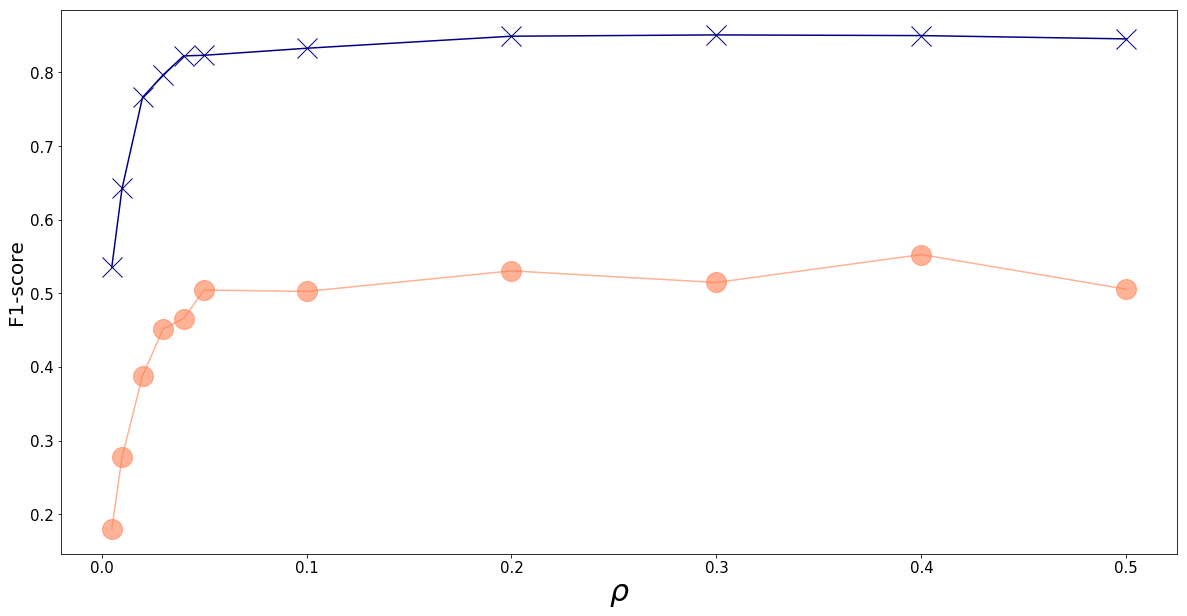

In [21]:

plt.plot(ScoreswrtAmplishocksIDTestMean.Ampli.values,ScoreswrtAmplishocksIDTrainMean.Prec.values,marker='x',markersize=20,c='navy')
plt.plot(ScoreswrtAmplishocksIDTestMean.Ampli.values,ScoreswrtAmplishocksIDTestMean.Prec.values,marker='o',alpha=0.6,markersize=20,c='coral')
plt.tick_params(axis='y',labelsize=15)
plt.tick_params(axis='x',labelsize=15)
plt.xlabel(r'$\rho$',fontsize=30)
plt.ylabel('F1-score',fontsize=20)

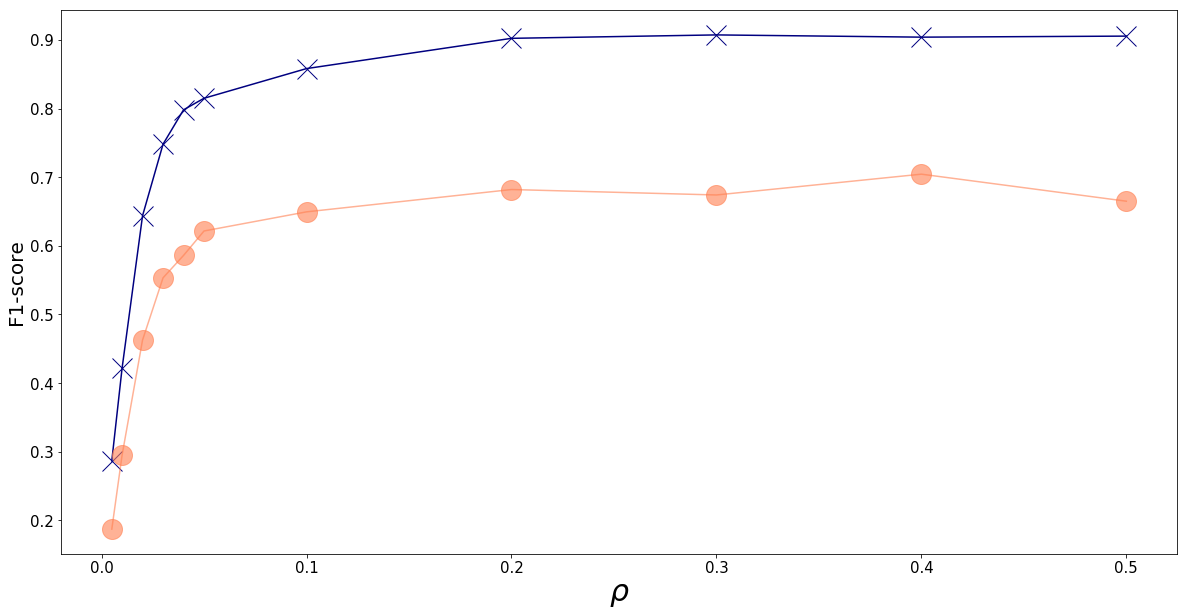

In [18]:

plt.plot(ScoreswrtAmplishocksIDTestMean.Ampli.values,ScoreswrtAmplishocksIDTrainMean.F1.values,marker='x',markersize=20,c='navy')
plt.plot(ScoreswrtAmplishocksIDTestMean.Ampli.values,ScoreswrtAmplishocksIDTestMean.F1.values,marker='o',alpha=0.6,markersize=20,c='coral')
plt.tick_params(axis='y',labelsize=15)
plt.tick_params(axis='x',labelsize=15)
plt.xlabel(r'$\rho$',fontsize=30)
plt.ylabel('F1-score',fontsize=20)
plt.savefig(r'C:\Users\nmadhar\Desktop\Conv_deep\Review\Results\Sensitivity2ShockAmplitude\Sens2AmpliMethod2IDStep.pdf')
plt.savefig(r'C:\Users\nmadhar\Desktop\Conv_deep\Review\Results\Sensitivity2ShockAmplitude\Sens2AmpliMethod2IDStep.png')
plt.show()

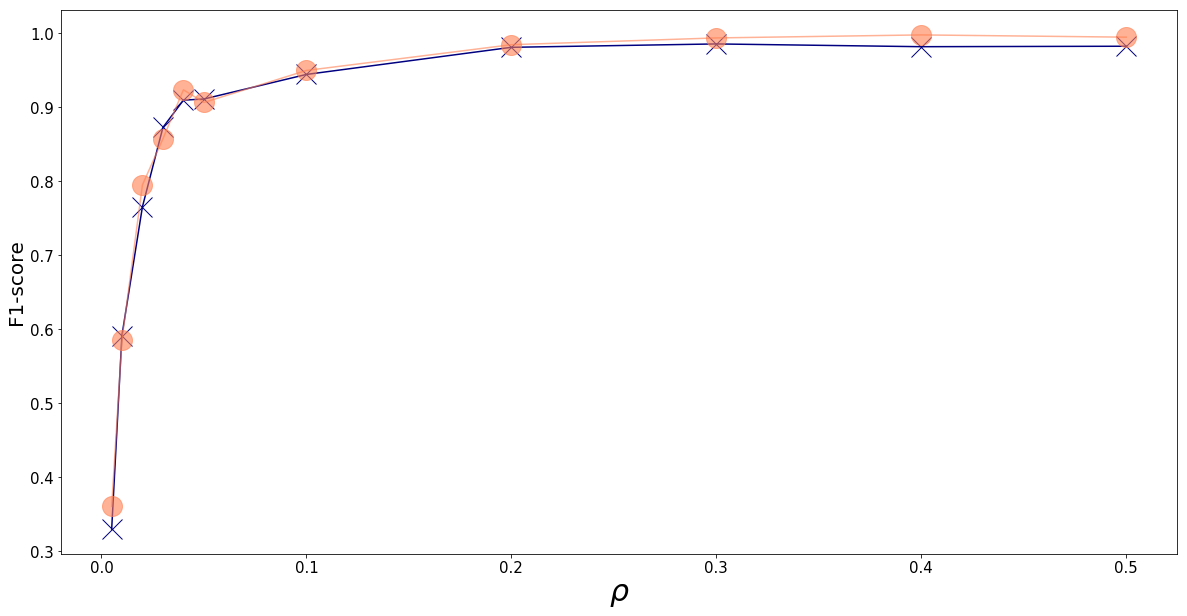

In [19]:

plt.plot(ScoreswrtAmplishocksLocTrainMean.Ampli.values,ScoreswrtAmplishocksLocTrainMean.F1.values,marker='x',markersize=20,c='navy')
plt.plot(ScoreswrtAmplishocksLocTrainMean.Ampli.values,ScoreswrtAmplishocksLocTestMean.F1.values,marker='o',alpha=0.6,markersize=20,c='coral')
plt.tick_params(axis='y',labelsize=15)
plt.tick_params(axis='x',labelsize=15)
plt.xlabel(r'$\rho$',fontsize=30)
plt.ylabel('F1-score',fontsize=20)
plt.savefig(r'C:\Users\nmadhar\Desktop\Conv_deep\Review\Results\Sensitivity2ShockAmplitude\Sens2AmpliMethod2LocStep.pdf')
plt.savefig(r'C:\Users\nmadhar\Desktop\Conv_deep\Review\Results\Sensitivity2ShockAmplitude\Sens2AmpliMethod2LocStep.png')
plt.show()

In [120]:
ScoreswrtAmplishocksIDTrainMean.to_csv(r'C:\Users\nmadhar\Desktop\ToSubmit\Results\ShockAmplitude\ScoreswrtAmplishocksIDTrainMean.csv')
ScoreswrtAmplishocksIDTrainStd.to_csv(r'C:\Users\nmadhar\Desktop\ToSubmit\Results\ShockAmplitude\ScoreswrtAmplishocksIDTrainStd.csv')

ScoreswrtAmplishocksIDTestMean.to_csv(r'C:\Users\nmadhar\Desktop\ToSubmit\Results\ShockAmplitude\ScoreswrtAmplishocksIDTestMean.csv')
ScoreswrtAmplishocksIDTestStd.to_csv(r'C:\Users\nmadhar\Desktop\ToSubmit\Results\ShockAmplitude\ScoreswrtAmplishocksIDTestStd.csv')


In [121]:
ScoreswrtAmplishocksLocTrainMean.to_csv(r'C:\Users\nmadhar\Desktop\ToSubmit\Results\ShockAmplitude\ScoreswrtAmplishocksLocTrainMean.csv')
ScoreswrtAmplishocksLocTrainStd.to_csv(r'C:\Users\nmadhar\Desktop\ToSubmit\Results\ShockAmplitude\ScoreswrtAmplishocksLocTrainStd.csv')

ScoreswrtAmplishocksLocTestMean.to_csv(r'C:\Users\nmadhar\Desktop\ToSubmit\Results\ShockAmplitude\ScoreswrtAmplishocksLocTestMean.csv')
ScoreswrtAmplishocksLocTestStd.to_csv(r'C:\Users\nmadhar\Desktop\ToSubmit\Results\ShockAmplitude\ScoreswrtAmplishocksLocTestStd.csv')
